In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation

/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [3]:
from preprocess import get_cortex
# all_subs = [100610, 125525]

In [3]:
import cfhcpy
from cfhcpy.base import AnalysisBase
from cfhcpy.base import AnalysisBase

/tank/klundert/projects/hcp_movie/cfhcpy/base.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/tank/klundert/projects/hcp_movie/cfhcpy/viz_utils.py:143: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if plot_type is 'polar':
/tank/klundert/projects/hcp_movie/cfhcpy/viz_utils.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif plot_type is 'rsq':


In [4]:
ab = AnalysisBase()

ab.startup(subject='999999', experiment_id="ret", yaml_file="/tank/klundert/projects/hcp_movie/config.yml")


Starting analysis of subject 999999 on romulus with settings 
{
 "identifier": "node230",
 "base_dir": "/scratch/2019/visual/hcp_{experiment}/",
 "code_dir": "/tank/tkn219/projects/hcp_movie/",
 "threads": 40
}


In [7]:
import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]



roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159, 'MIP': 50
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


# ind = np.array(list(roi_index_dict.values()))[12:]
# boolmask_old = atlas_data_both_hemis == roi_index_dict['V2']
# for i, ROIs in enumerate(ind):
#     boolmask_old = np.array(atlas_data_both_hemis == ind[i]) + boolmask_old
#     print(ROIs)

In [ ]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159, 'MIP': 50
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

In [908]:
np.unique(df['Lobe'].values)

array(['Fr', 'Ins', 'Occ', 'Par', 'Temp'], dtype=object)

In [905]:
import pandas as pd
df = pd.read_csv('/tank/klundert/projects/cfdn/scripts/ROI.csv')

df['regionID'][df['Cortex_ID'] < 6][df['regionID'][df['Cortex_ID'] < 6]<181].values[1:]


array([  2,   3,   4,   5,   6,   7,  13,  16,  17,  18,  19,  20,  21,
        22,  23, 138, 152, 153, 154, 156, 157, 158, 159, 160, 163])

In [895]:
cortex_index_dict = {
    'Early_visual': [4, 5, 6],
    'Ventral_stream': [7, 18, 22, 153, 154, 160, 163],
    'Dorsal_stream': [3, 13,  16,  17,  19, 152],
    '': [2,  20,  21,  23, 138, 156, 157, 158, 159]
    }

In [924]:
cortex_index_dict = {
    'Fr': [  8,  10,  11,  12,  26,  40,  41,  43,  44,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,
        97,  98,  99, 108, 111, 113, 115, 164, 165, 166, 169, 170, 171,
       179, 180],
    'Occ': [1,   2,   3,   4,   5,   6,   7,  13,  15,  16,  19,  20,  21,
        22,  23, 141, 142, 143, 146, 152, 153, 154, 156, 157, 158, 159,
       160],
    'Par': [  9,  14,  17,  25,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  42,  45,  46,  47,  48,  49,  50,  51,  52,
        95, 100, 101, 102, 104, 105, 116, 117, 121, 140, 144, 145, 147,
       148, 149, 150, 151, 161, 162],
    'Temp': [ 18,  24, 103, 107, 110, 118, 119, 120, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       155, 163, 172, 173, 174, 175, 176, 177, 178],
    'Ins': [106, 109, 112, 114, 167, 168]
    }

In [925]:
df['regionID'][df['Lobe'] == 'Ins'][df['regionID']<181].values[:]

array([106, 109, 112, 114, 167, 168])

In [918]:
import pandas as pd
df = pd.read_csv('/tank/klundert/projects/cfdn/scripts/ROI.csv')
df
# df['regionID'][df['Cortex_ID'] < 6][df['regionID'][df['Cortex_ID'] < 6]<181].values[1:]
for lobe in ['Fr', 'Ins', 'Occ', 'Par', 'Temp']:
    print(lobe)
    print(df['regionID'][df['Lobe'] == lobe][df['regionID']<181].values[:])
# df['cortex'][df['Cortex_ID'] < 6]

Fr
[  8  10  11  12  26  40  41  43  44  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98
  99 108 111 113 115 164 165 166 169 170 171 179 180]
Ins
[106 109 112 114 167 168]
Occ
[  1   2   3   4   5   6   7  13  15  16  19  20  21  22  23 141 142 143
 146 152 153 154 156 157 158 159 160]
Par
[  9  14  17  25  27  28  29  30  31  32  33  34  35  36  37  38  39  42
  45  46  47  48  49  50  51  52  95 100 101 102 104 105 116 117 121 140
 144 145 147 148 149 150 151 161 162]
Temp
[ 18  24 103 107 110 118 119 120 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 155 163 172 173 174 175 176 177 178]


In [373]:


atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


ind = df['regionID'][df['Cortex_ID'] < 6][df['regionID'][df['Cortex_ID'] < 6]<181].values[1:]
boolmask_new = atlas_data_both_hemis == roi_index_dict['V2']
for i, ROIs in enumerate(ind):
    boolmask_new = np.array(atlas_data_both_hemis == ind[i]) + boolmask_new
    print(ROIs)
    
boolmask = boolmask_new + boolmask_old

2
3
4
5
6
7
13
16
17
18
19
20
21
22
23
138
152
153
154
156
157
158
159
160
163


In [17]:
mydat = mh.decompose_data(data)

In [371]:
del boolmask
del boolmask_old
del boolmask_new

In [8]:
sub = 2
fold = 1

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


[50.10816577  3.78959492]


/tank/klundert/downloads/prfpy/prfpy/utils.py:222: RuntimeWarning: divide by zero encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:222: RuntimeWarning: invalid value encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:291: RuntimeWarning: divide by zero encountered in true_divide
  return a/(b+x)


0.2

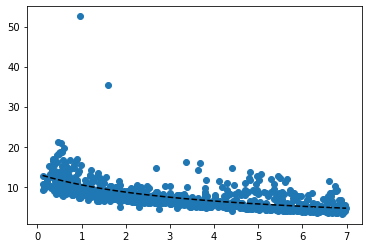

In [9]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, ab.prf_ecc_threshold, ab.prf_rsq_threshold)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

ab.prf_ecc_threshold
ab.prf_rsq_threshold

In [534]:
ac.prf_parameter_h5file

'/scratch/2019/visual/hcp_ret/999999/V12_retmap_results_polar_bar_iterative.h5'

In [589]:
what = h5py.File('/scratch/2019/visual/hcp_ret/subjects/100610/V12_retmap_results_polar_bar_iterative.h5', "r")


In [514]:
what = h5py.File('/scratch/2019/visual/hcp_ret/999999/V12_retmap_results_polar_bar_iterative.h5', "r")
V1_params = np.concatenate([np.array(what['prf_grid_parameters']['v1_L']), np.array(what['prf_grid_parameters']['v1_R'])])



In [11]:
boolmask_V1 = atlas_data_both_hemis == roi_index_dict['V1']
boolmask_V1.sum()

2939

In [76]:
np.array(what['prf_iterative_parameters'])

array(['v12_L', 'v12_R', 'v1_L', 'v1_R', 'v2_L', 'v2_R'], dtype='<U5')

In [237]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

V1_mask = np.concatenate([maskL,maskR])

In [238]:
V1_mask = np.concatenate([maskL,maskR])
V1_mask.sum()

2890

In [81]:
ab.atlas_label_filename
ab.

'/scratch/2019/visual/hcp_ret/surfaces/atlas/Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'

In [16]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

In [17]:
boolmask = atlas_data_both_hemis == roi_index_dict['V1']
boolmask.sum()
V1_params[:,3].shape

(2939,)

In [819]:
np.array(what['prf_iterative_parameters']['v1_L']).shape
1430 + 1509

V1_params = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L']), np.array(what['prf_iterative_parameters']['v1_R'])])

In [173]:
V1_params = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L']), np.array(what['prf_iterative_parameters']['v1_R'])])
V1_params[:,-1][V1_params[:,-1] < 0.3] = np.nan

prfecc = np.zeros(boolmask.shape)
prfecc[:] = np.nan
# prfecc[boolmask] = ecc(V1_params[:,0], V1_params[:,1])

# prfecc[boolmask] = V1_params[:,-1]
# integermask = myv1surf.intmask == 1

# prfecc[integermask] = myv1surf.CMF

prfecc[integermask] = myv1surf.visual_distance_matrix[0]
prfecc[~V1_mask] = np.nan
                                                   
cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True);
plt.title('CMF')

In [759]:
np.where(ecc(V1_params[:,0], V1_params[:,1])[integermask[boolmask]] > 8.5)[0]

array([ 571,  572,  573,  574,  575,  576,  578,  580,  581,  582,  584,
        585,  586,  587,  588,  589,  590,  591,  592,  593,  597,  599,
        600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,
        611,  615,  616,  617,  618,  624,  625,  632,  639,  640,  641,
        642,  643, 1125, 1127, 1129, 1131, 1149, 1151, 1152, 1153, 1154,
       1155, 1156, 1157, 1158, 1159, 1160, 1172, 1173, 1174, 1175, 1176,
       1177, 1178, 1179, 1180, 1183, 1184, 1188, 1189, 1199, 1200, 1201,
       1202, 1203])

In [775]:
waar = np.where(ecc(V1_params[:,0], V1_params[:,1])[integermask[boolmask]] >8)[0]
waar



array([ 562,  570,  571,  572,  573,  574,  575,  576,  577,  578,  579,
        580,  581,  582,  583,  584,  585,  586,  587,  588,  589,  590,
        591,  592,  593,  597,  598,  599,  600,  601,  602,  603,  604,
        605,  606,  607,  608,  609,  610,  611,  615,  616,  617,  618,
        624,  625,  632,  639,  640,  641,  642,  643, 1124, 1125, 1126,
       1127, 1128, 1129, 1130, 1131, 1149, 1150, 1151, 1152, 1153, 1154,
       1155, 1156, 1157, 1158, 1159, 1160, 1161, 1163, 1171, 1172, 1173,
       1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1183, 1184, 1188,
       1189, 1199, 1200, 1201, 1202, 1203])

In [753]:
integermask = myv1surf.intmask == 1

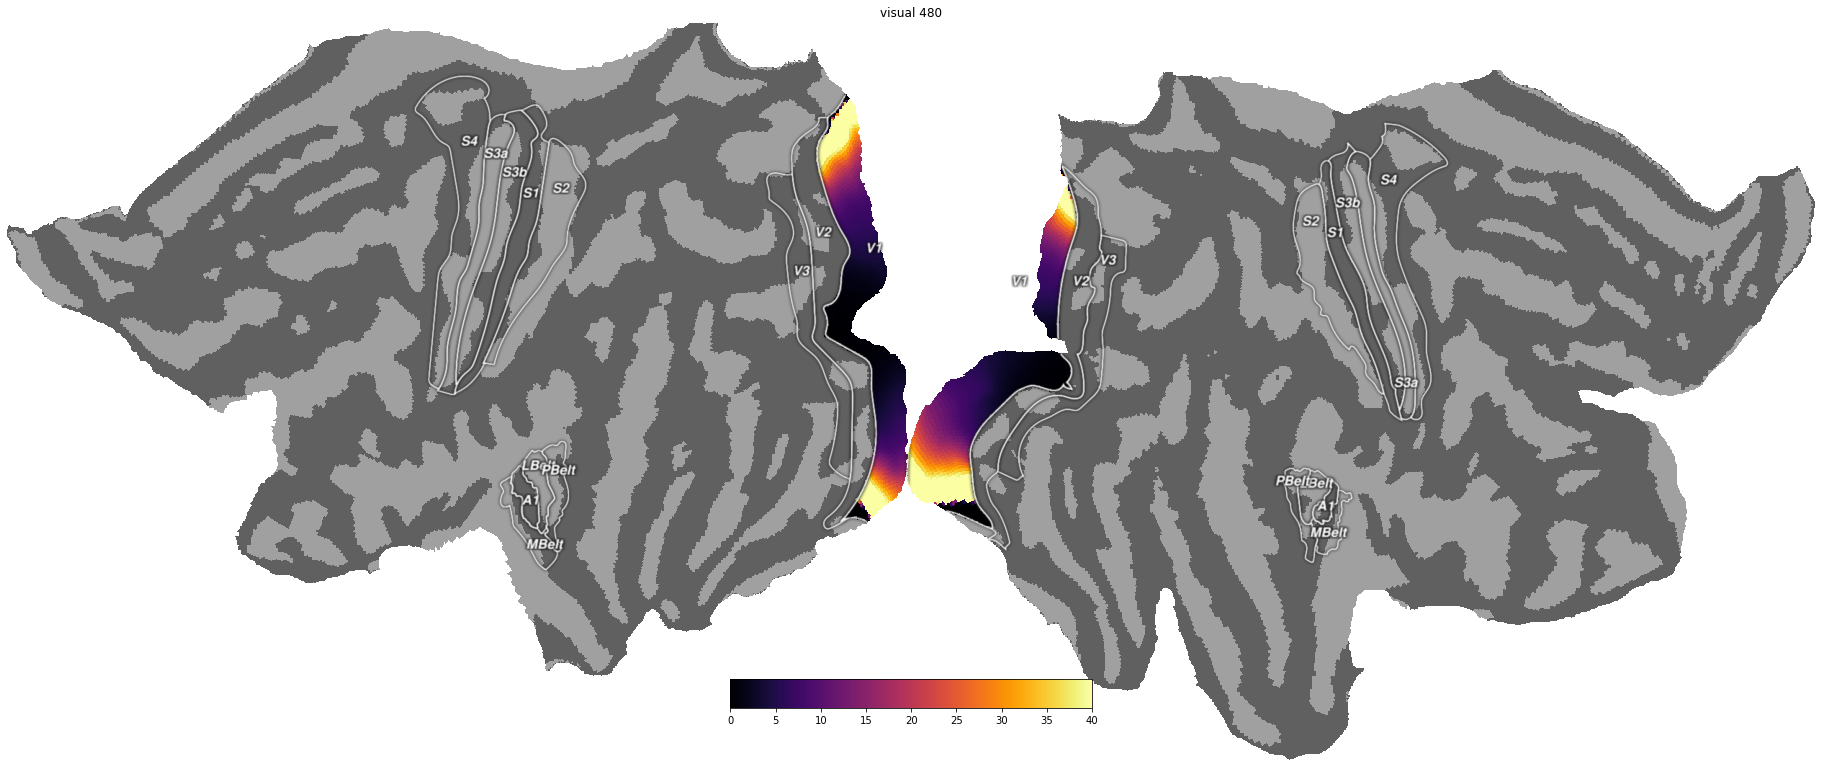

In [750]:
# myv1surf.visual_distance_matrix[100]

prfecc[V1_mask] = myv1surf.visual_distance_matrix[30]
prfecc[~V1_mask] = np.nan
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=40), with_curvature=True);
plt.title(f'visual {i}')
plt.show()

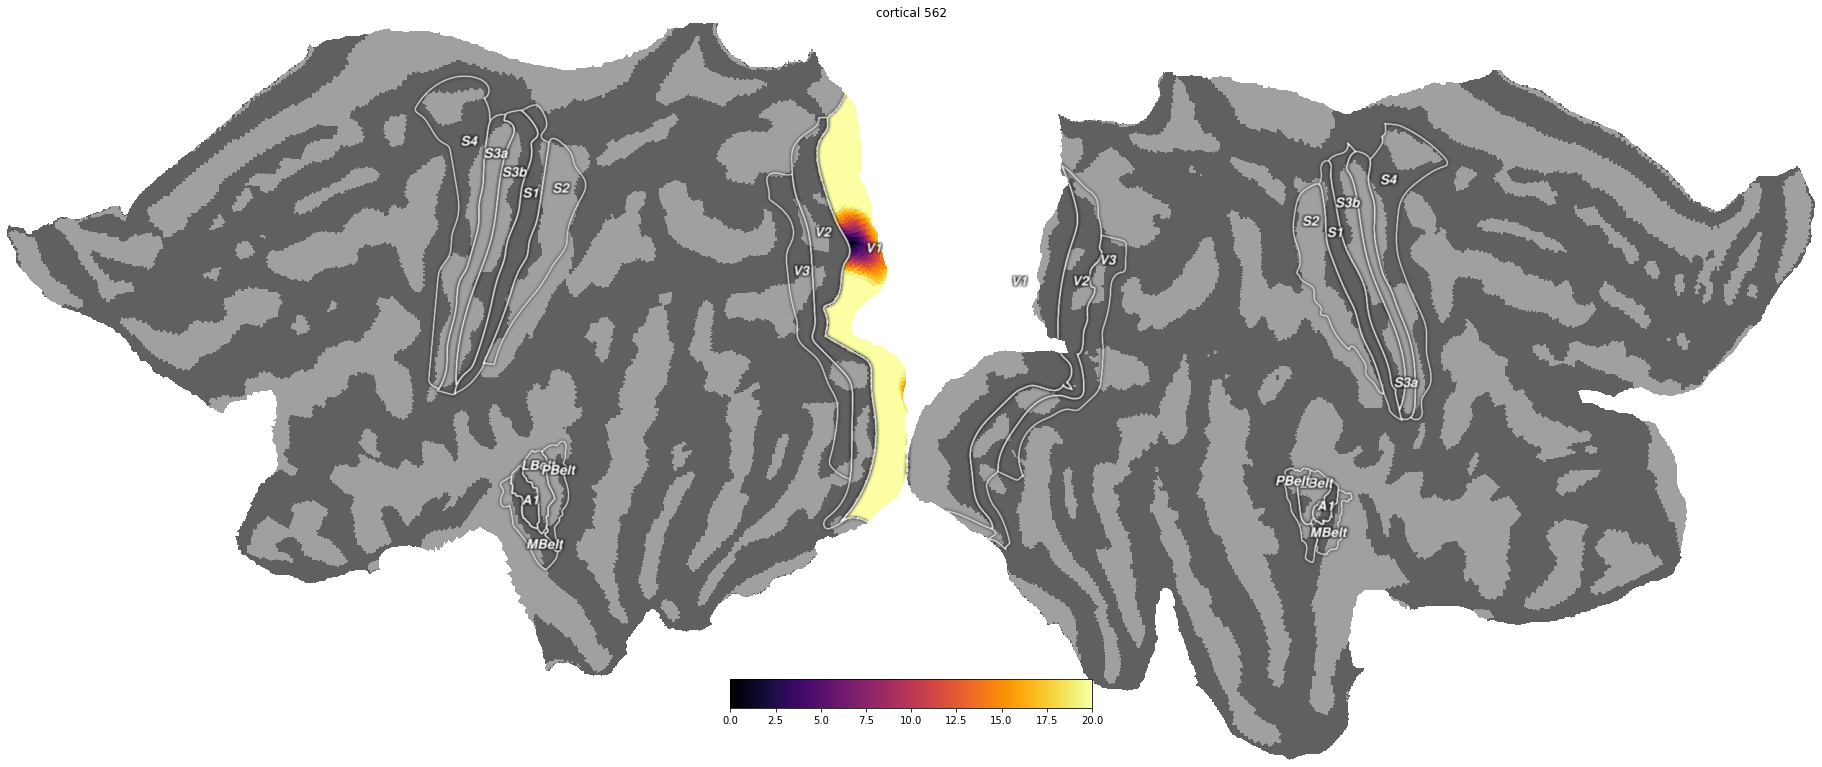

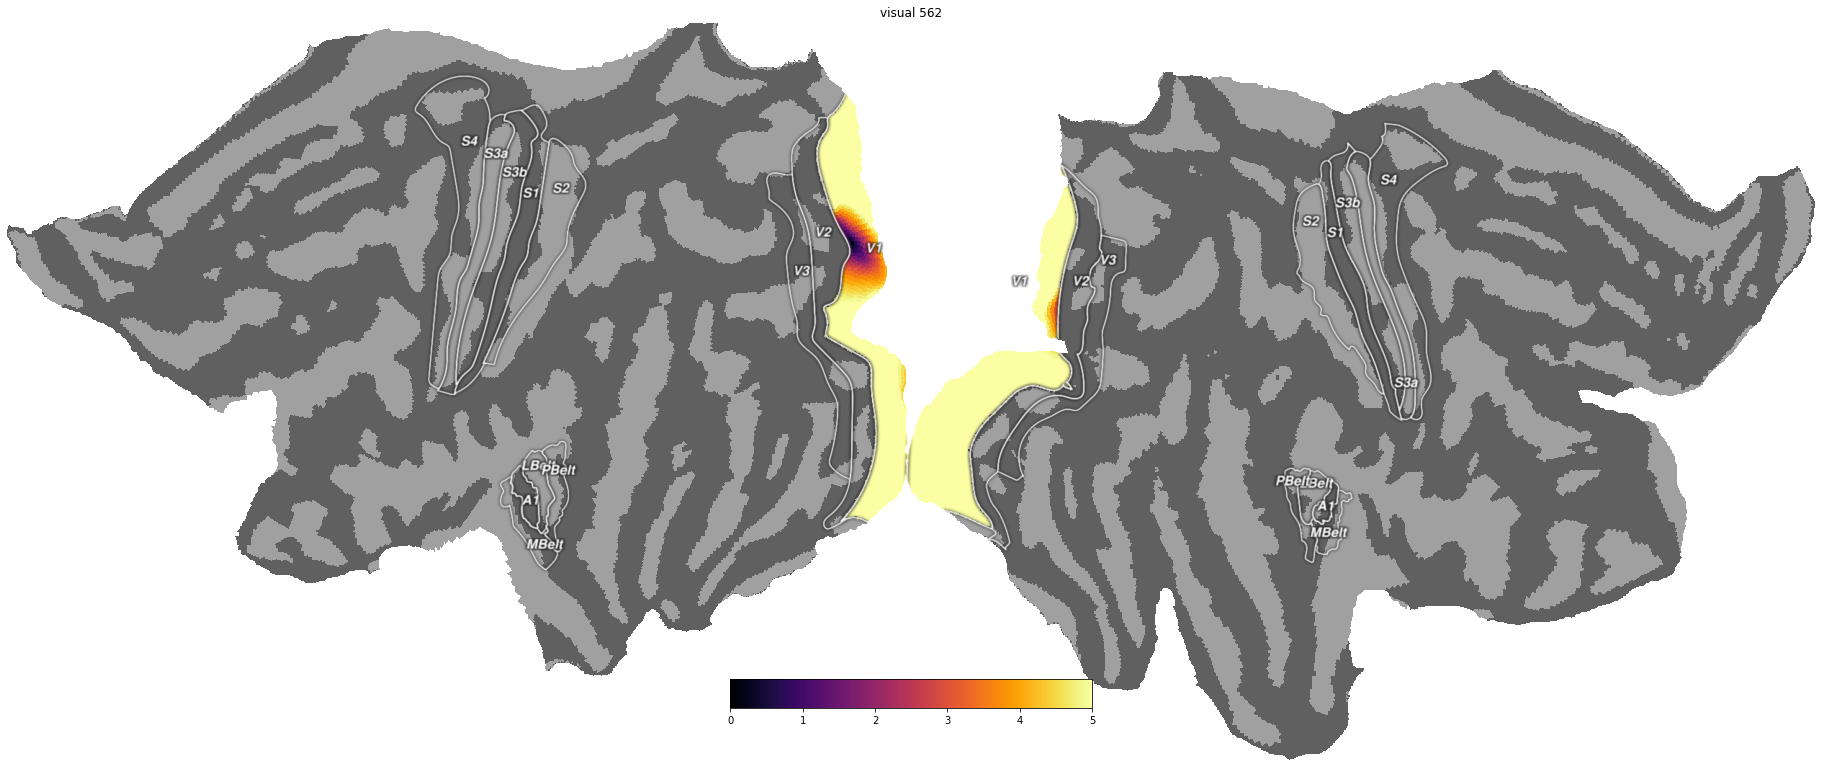

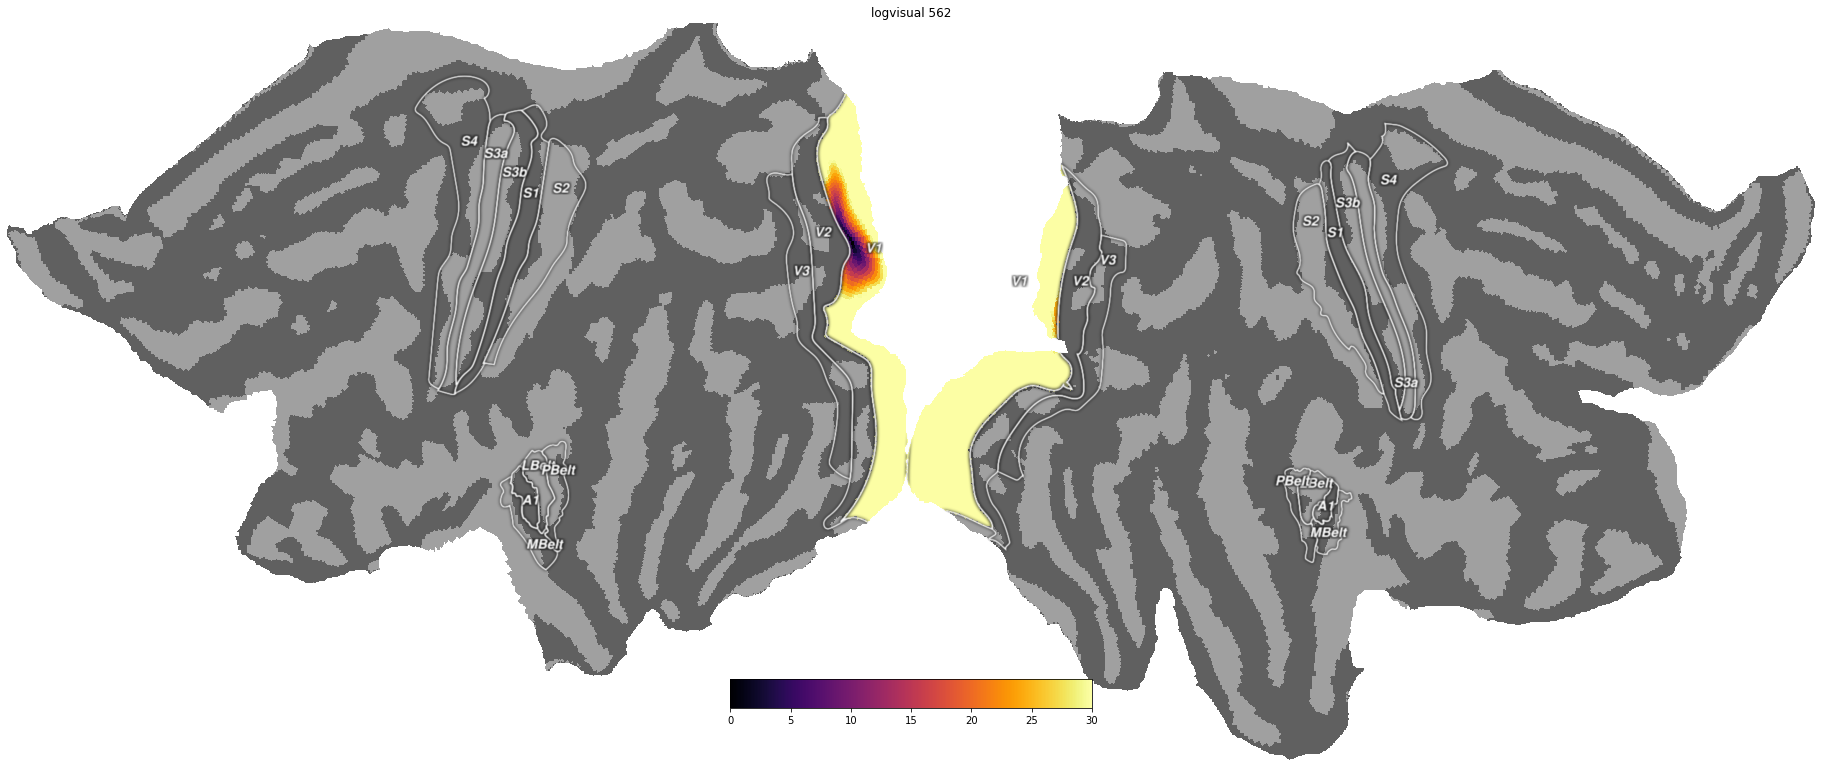

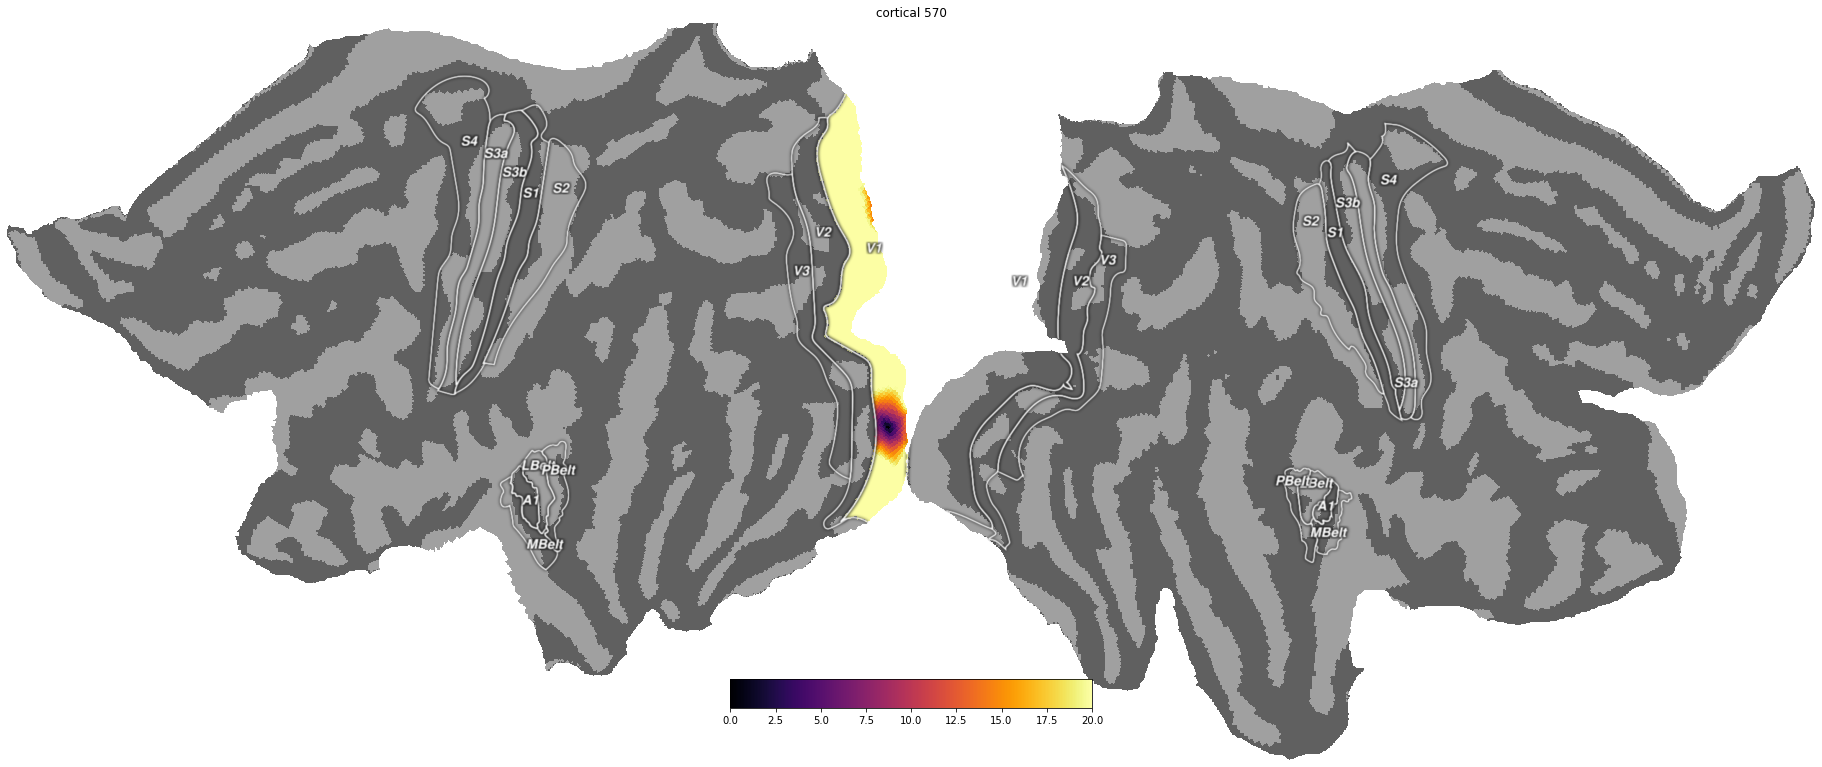

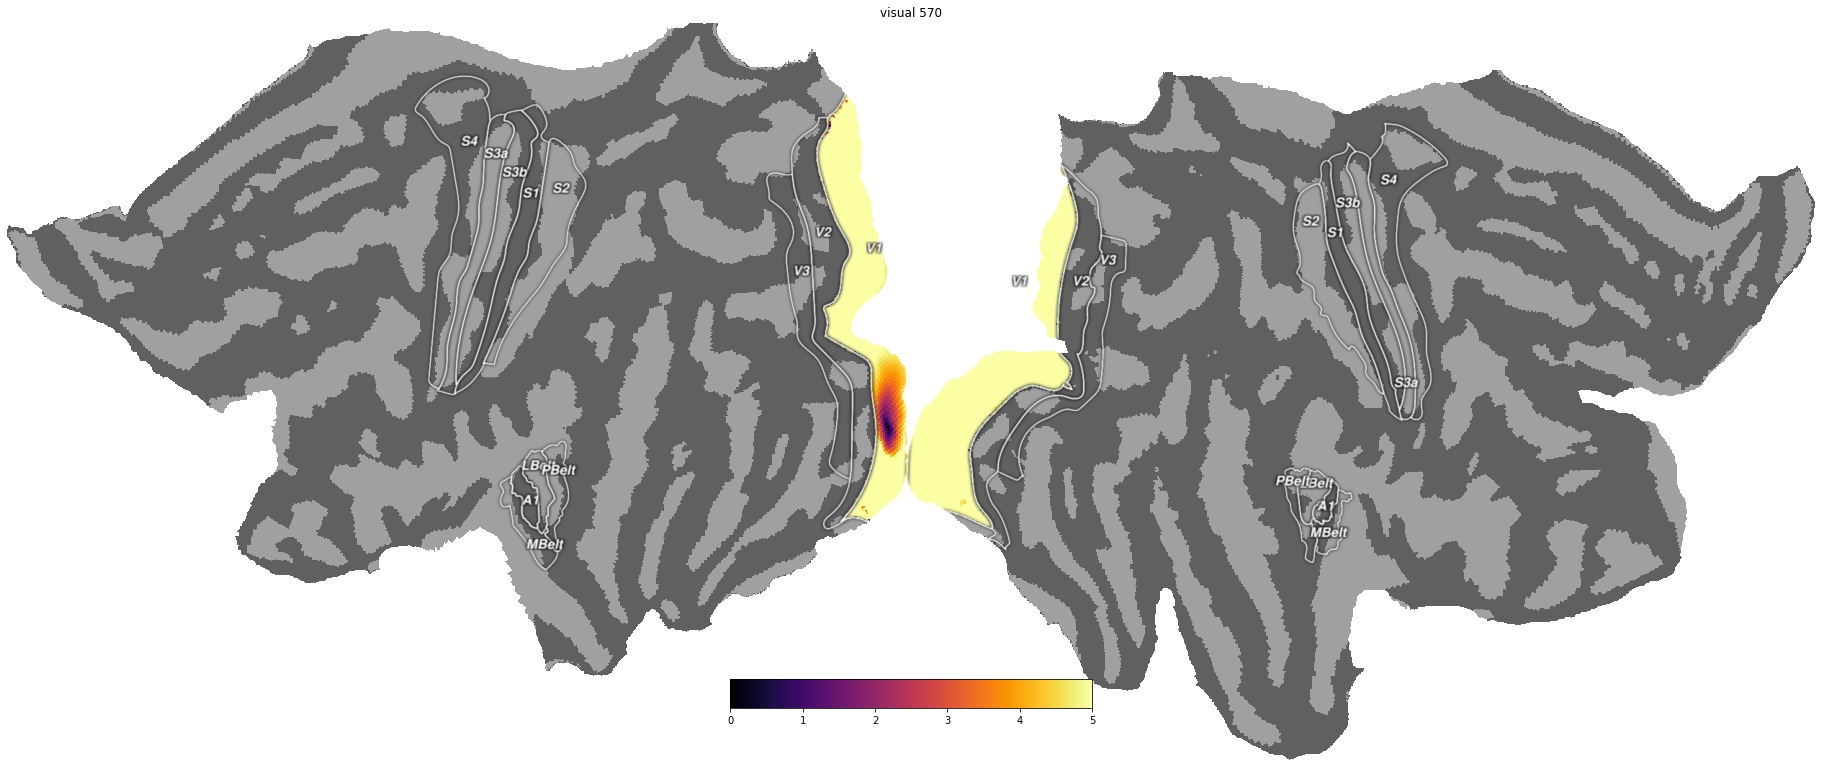

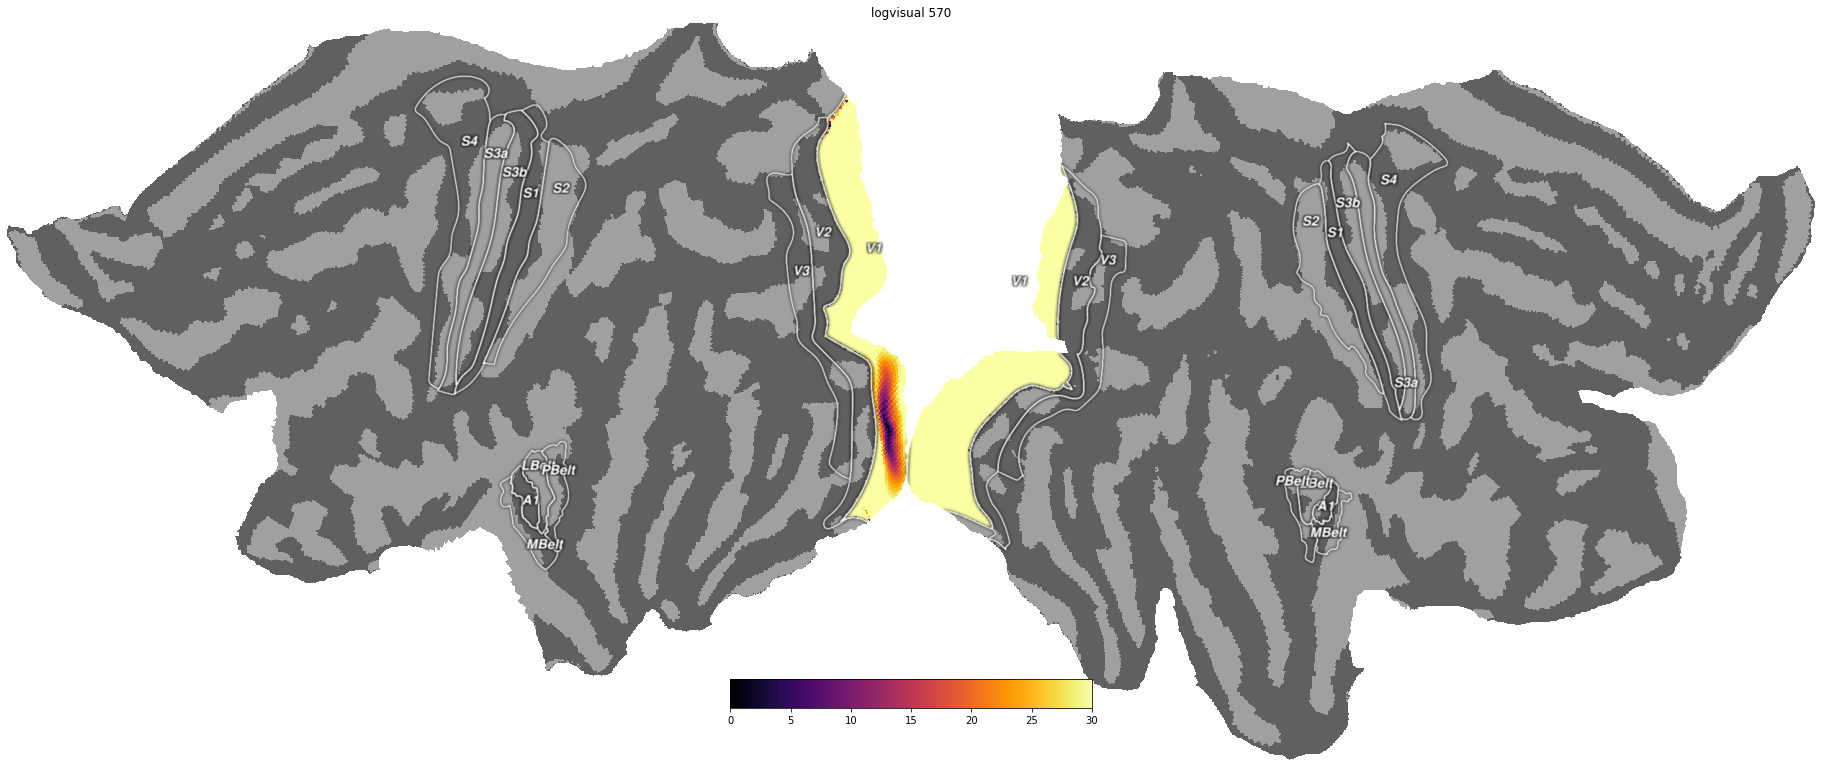

In [784]:
prfecc = np.zeros(boolmask.shape)
prfecc[:] = np.nan


for i in waar[:1]:
    
    prfecc[V1_mask] = myv1surf.distance_matrix[i]
    prfecc[~V1_mask] = np.nan
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
    cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=20), with_curvature=True);
    plt.title(f'cortical {i}')
    plt.show()
    
    prfecc[V1_mask] = myv1surf.visual_distance_matrix[i]
    prfecc[~V1_mask] = np.nan
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
    cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=5), with_curvature=True);
    plt.title(f'visual {i}')
    plt.show()
    
    prfecc[V1_mask] = myv1surf.logvisual_distance_matrix[i]
    prfecc[~V1_mask] = np.nan
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
    cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=30), with_curvature=True);
    plt.title(f'logvisual {i}')
    plt.show()

In [789]:

i = waar[0]
prfecc[V1_mask] = myv1surf.distance_matrix[i]
prfecc[~V1_mask] = 20
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
cx.webgl.show(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=20), with_curvature=True, port=8810);
plt.title(f'cortical {i}')
plt.show()

# prfecc[V1_mask] = myv1surf.visual_distance_matrix[i]
# prfecc[~V1_mask] = np.nan
# #     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
# cx.webgl.show(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=5), with_curvature=True, port=8811);
# plt.title(f'visual {i}')
# plt.show()

Started server on port 8810


KeyboardInterrupt: 

In [ ]:
prfecc[V1_mask] = myv1surf.visual_distance_matrix[i]
prfecc[~V1_mask] = 5
#     print(np.nanmin(myv1surf.visual_distance_matrix[i]))
cx.webgl.show(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0, vmax=5), with_curvature=True, port=8811);
plt.title(f'visual {i}')
plt.show()

Started server on port 8811


In [ ]:
cx.webgl.show(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-2, vmax=2), port=8810)

Text(0.5, 1.0, 'CMF')

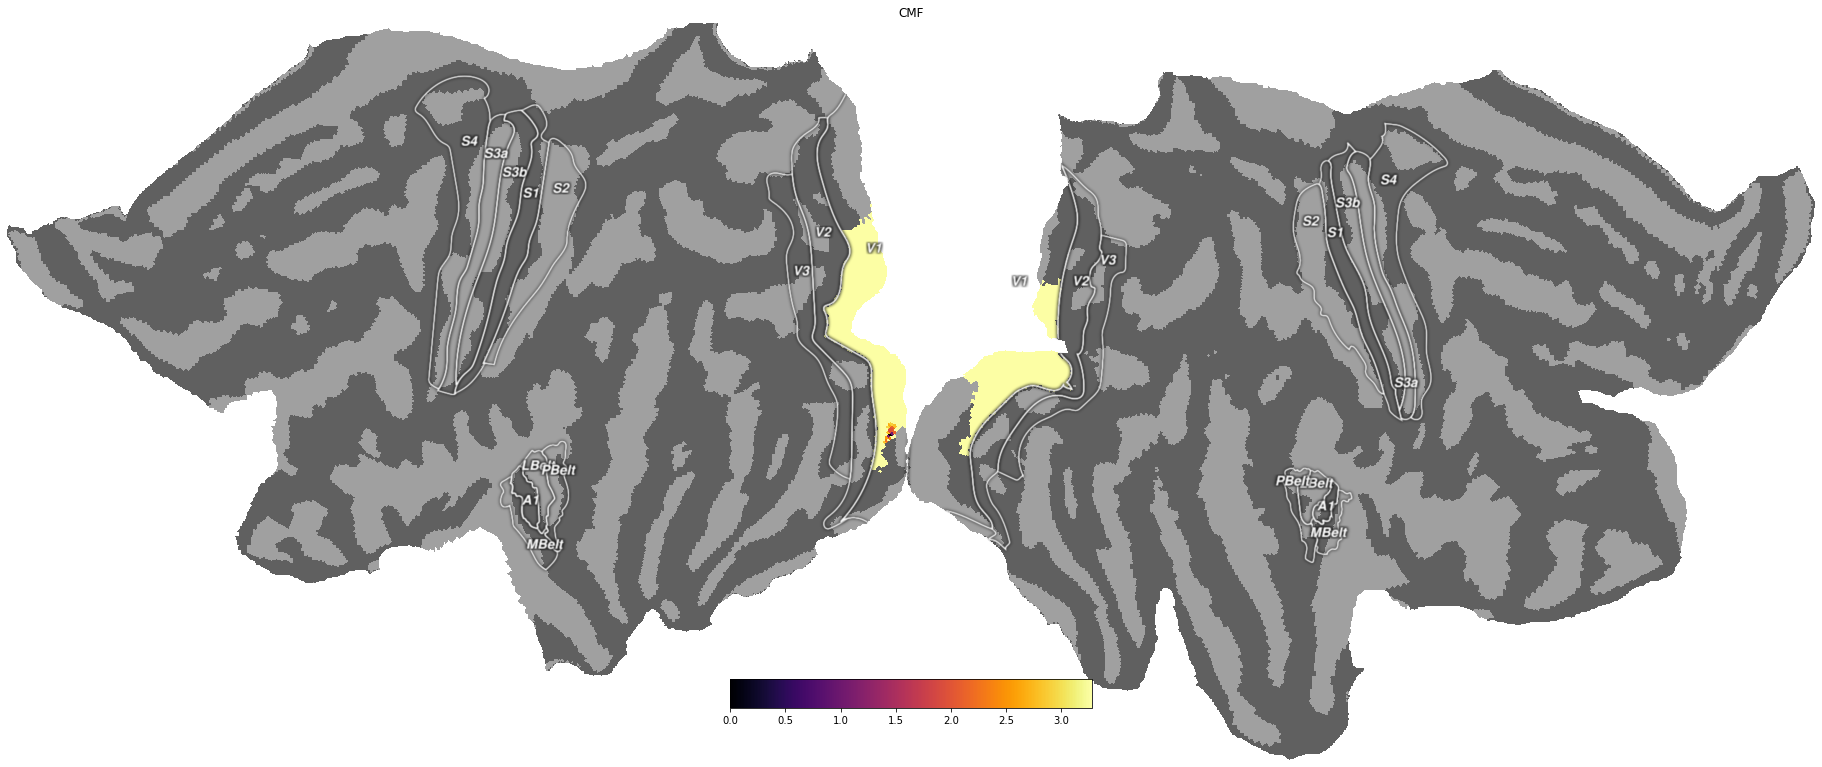

In [764]:
cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True);
plt.title('CMF')

In [221]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, ab.prf_ecc_threshold, ab.prf_rsq_threshold)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

ab.prf_ecc_threshold
ab.prf_rsq_threshold

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


NameError: name 'sub' is not defined

In [26]:
np.nanmax(gfn_ecc)

384025.0597835516

In [31]:
np.nanmax(gfn_ecc)

15.580511189150807

In [23]:
prfecc = np.zeros(get_cortex(data.T).mean(axis=1).shape)
prfecc[:] = np.nan
prfecc[boolmask] = angle(V1_params[:,0], V1_params[:,1])
prfecc[~V1_mask] = np.nan

NameError: name 'angle' is not defined

In [65]:
ab.prf_ecc_threshold

7.0

In [14]:
V1_params = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L']), np.array(what['prf_iterative_parameters']['v1_R'])])
V1_params_full = np.zeros([118584, 6])
V1_params_full[:] = np.nan
V1_params_full[boolmask] = V1_params
V1_params_full[~V1_mask] = np.nan

NameError: name 'boolmask' is not defined

In [723]:
integermask.sum()

1434

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/downloads/prfpy/prfpy/utils.py:166: RuntimeWarning: invalid value encountered in less
  eccMask = ecc < maxecc
/tank/klundert/downloads/prfpy/prfpy/utils.py:167: RuntimeWarning: invalid value encountered in greater
  rsqMask = rsq > maxrsq
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: divide by zero encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: invalid value encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide by zero encountered in true_divide
  return a/(b+x)
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide b

[48.35656104  3.16327226]
[48.35656104  3.16327226]


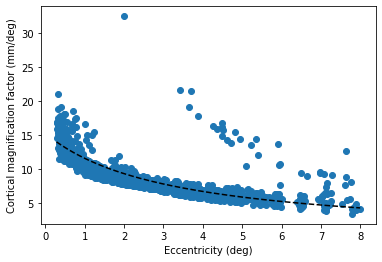

In [853]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

# load prf paramaters for creating visual space distance matrix and limiting the vertices
what = h5py.File(ab.prf_parameter_h5file, "r")
V1_params = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L']), np.array(what['prf_iterative_parameters']['v1_R'])])
V1_params_full = np.zeros([118584, 6])
V1_params_full[:] = np.nan
V1_params_full[boolmask] = V1_params
V1_params_full[~V1_mask] = np.nan
gfn_ecc = ecc(V1_params_full[:,0], V1_params_full[:,1])
gfn_rsq = V1_params_full[:,-1]
# max_ecc_size = ab.prf_ecc_threshold
max_ecc_size = 8
maxrsq = 0.0001
# maxrsq = np.nanmax(gfn_rsq)

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq)
myv1surf.create_visual_space(V1_params_full[:,0], V1_params_full[:,1])

In [584]:
V1_params_full[:,0]

array([nan, nan, nan, ..., nan, nan, nan])

In [157]:
(myv1surf.distance_matrix/myv1surf.visual_distance_matrix)[29][61]
(myv1surf.visual_distance_matrix)
myv1surf.visual_distance_matrix[29][61]

/tank/klundert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/tank/klundert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.006280472938018624

In [158]:
# pars = [46.60976917, 3.22366307]
myv1surf.CMF
for i, j in enumerate(range(100)):
    print(j)
    print(np.nanmax((myv1surf.distance_matrix/myv1surf.visual_distance_matrix)[i]))
# np.nanmean(myv1surf.visual_distance_matrix, axis=1)[myv1surf.ecc > 14.5]


In [794]:
integermask = myv1surf.intmask == 1

In [284]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def angle_deg(x0, y0):
    return np.angle(x0 + y0 * 1j, deg=True)

In [ ]:
integermask = myv1surf.intmask == 1

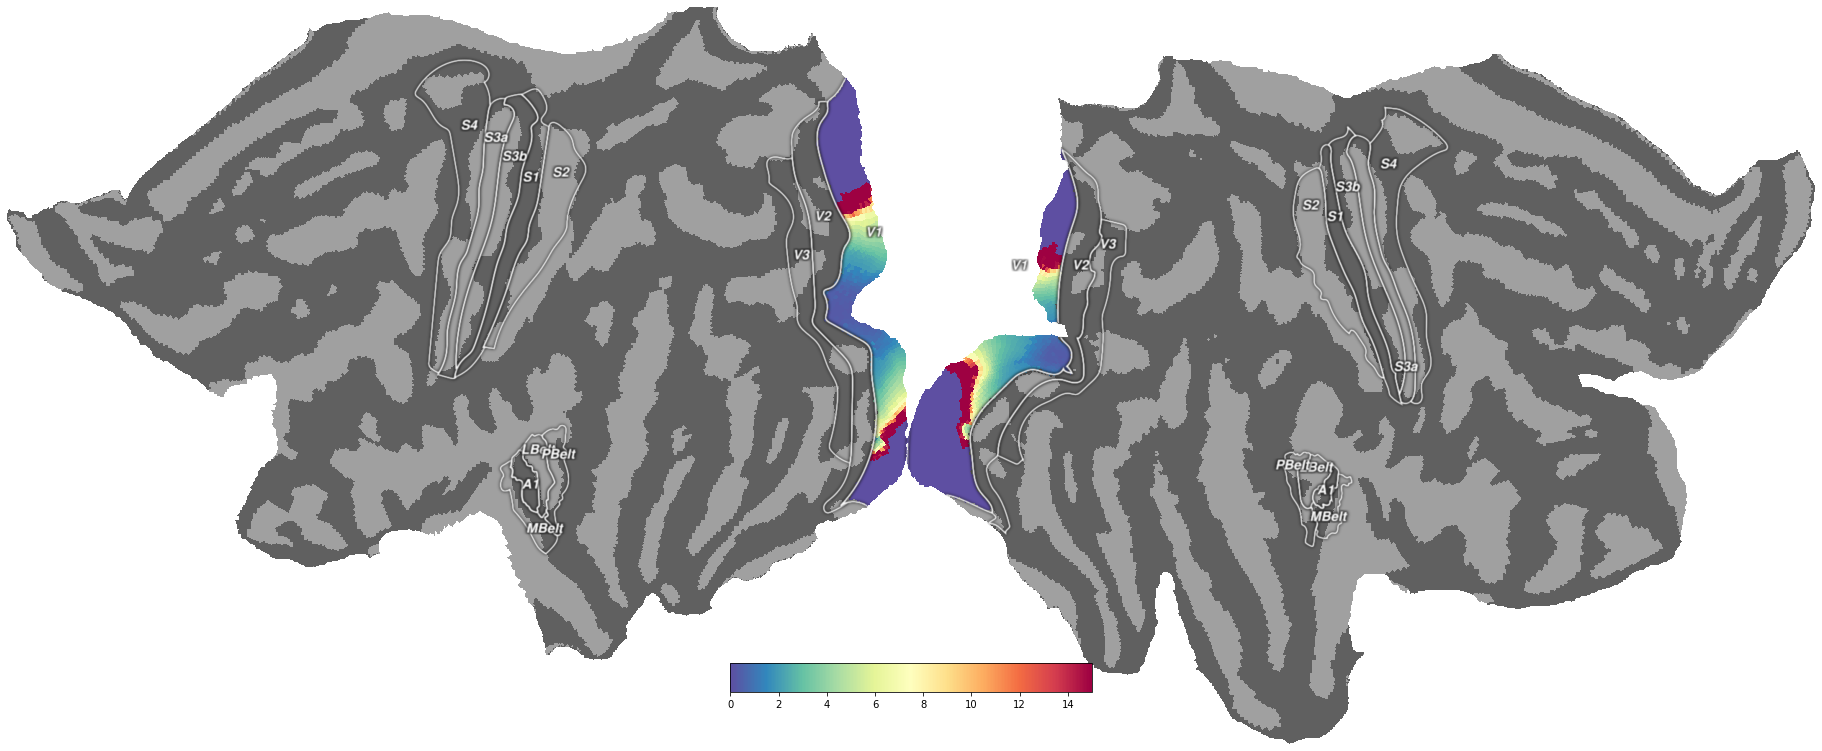

In [560]:
prfecc[boolmask] = ecc(V1_params[:,0], V1_params[:,1])
prfecc[~V1_mask] = np.nan

cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='spectral_r', vmin=0, vmax=15), with_curvature=True);


array([1., 1., 1., ..., 1., 1., 1.])

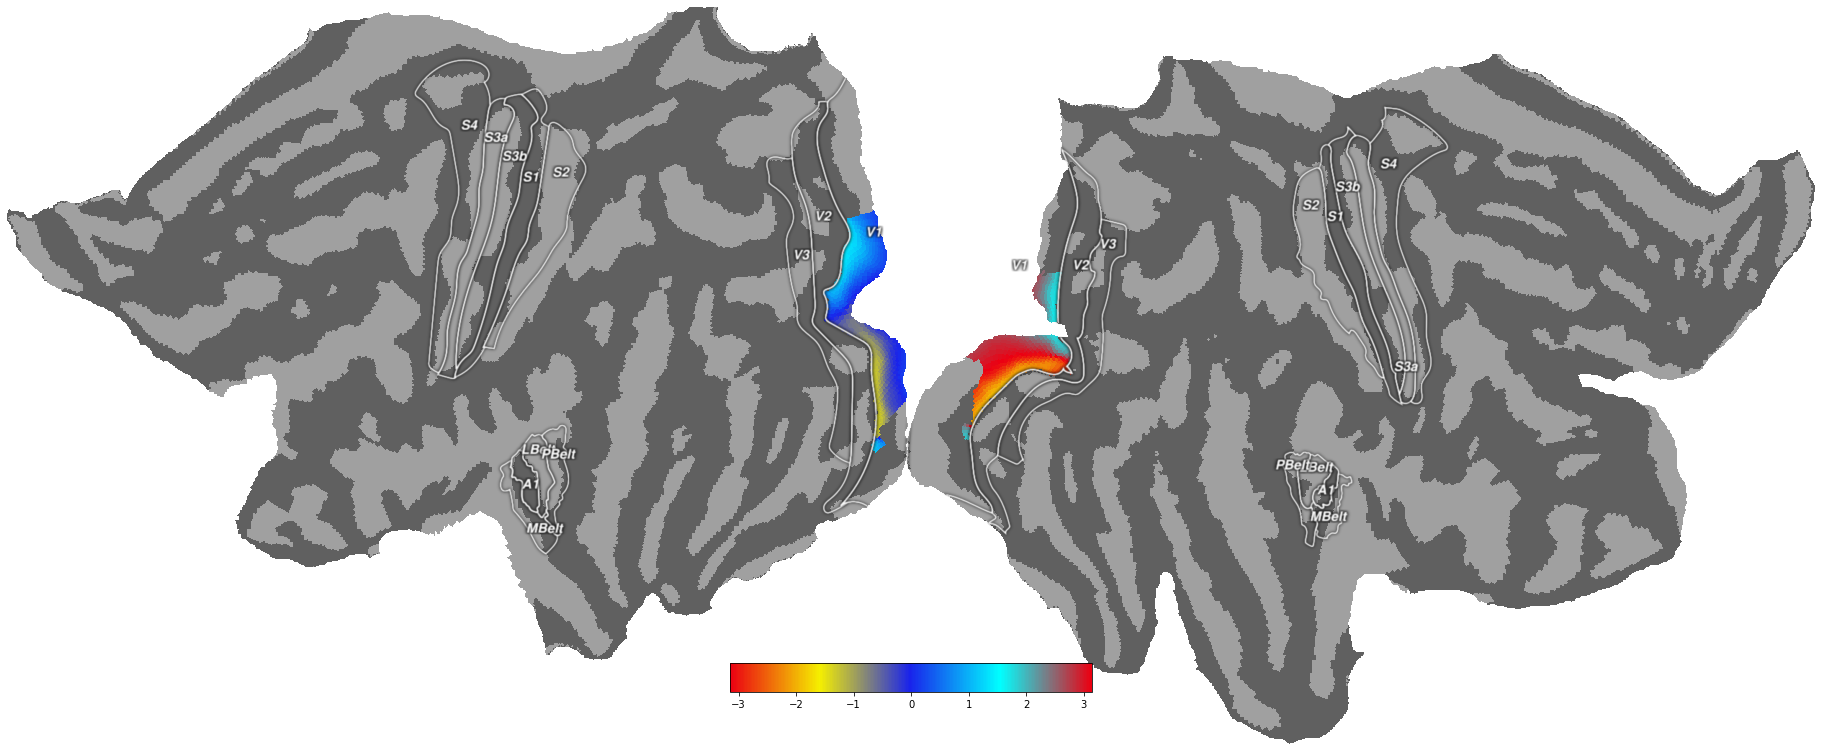

In [817]:
# prfecc[boolmask] = angle(V1_params[:,1], V1_params[:,0])
# prfecc[~V1_mask] = np.nan
# prfecc[~integermask] = np.nan
# cx.webgl.show(cx.Vertex(prfecc, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, port=8810)
cx.quickshow(cx.Vertex(prfecc, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi));


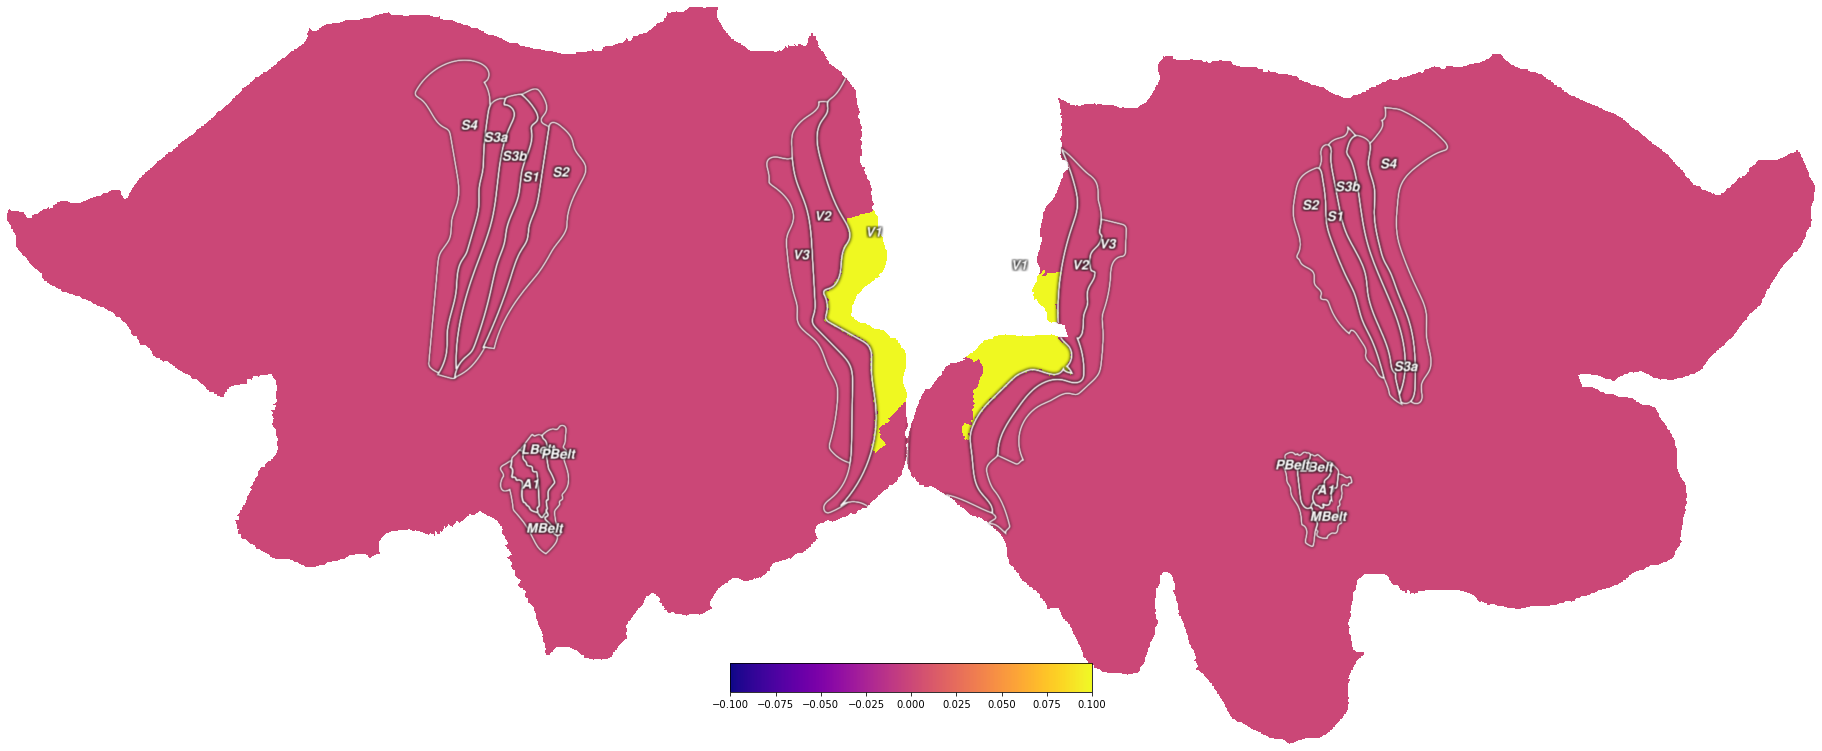

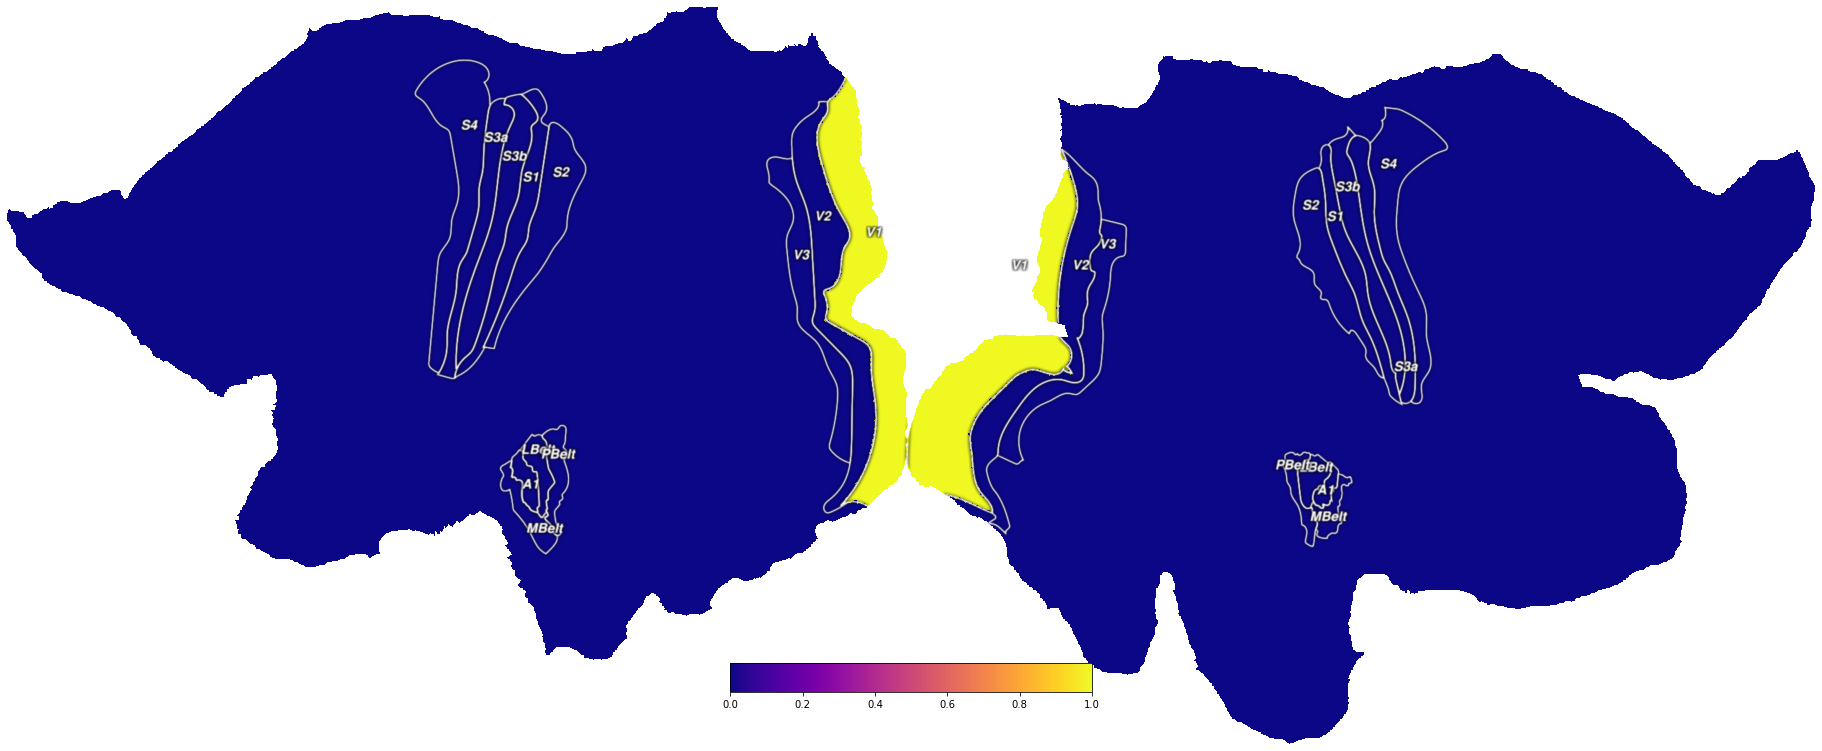

In [227]:
cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma'), with_curvature=True);
cx.quickshow(cx.Vertex(V1_mask.astype(int), subject='hcp_999999', cmap='plasma'), with_curvature=True);


In [ ]:
train_stim=CFStimulus(mydat_train, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)
test_stim=CFStimulus(mydat_test, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)

In [ ]:
train_stim=CFStimulus(mydat_train, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)
test_stim=CFStimulus(mydat_test, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)

71.03237249941307

In [ ]:
sub = sys.argv[1]
ses = sys.argv[2]
n_jobs = int(sys.argv[3])
sl = int(sys.argv[4])
mask_type = sys.argv[5]
hrf_delay = float(sys.argv[7])
postFix = sys.argv[6]+'_hrf%.2f'%hrf_delay
k = int(sys.argv[8])

In [202]:
ac = AnalysisBase()
# ac.startup(subject='999999', experiment_id="ret", yaml_file="/tank/klundert/projects/hcp_movie/config.yml")

In [240]:
ab.full_data_subjects
ac.startup(subject='100610', experiment_id="ret", yaml_file="/tank/klundert/projects/hcp_movie/config.yml")
mydat_train_stim = get_cortex(ac._read_tc_data(run=0).T)
mydat_test_stim = get_cortex(ac._read_tc_data(run=1).T)
LO1mask = atlas_data_both_hemis == roi_index_dict['LO1']


Starting analysis of subject 100610 on romulus with settings 
{
 "identifier": "node230",
 "base_dir": "/scratch/2019/visual/hcp_{experiment}/",
 "code_dir": "/tank/tkn219/projects/hcp_movie/",
 "threads": 40
}
Getting whole-brain data from: /scratch/2019/visual/hcp_ret/subjects/100610/tfMRI_RETBAR1_*_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc.nii
Getting whole-brain data from: /scratch/2019/visual/hcp_ret/subjects/100610/tfMRI_RETBAR2_*_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc.nii


In [854]:
myv1surf.visual_distance_matrix.shape
np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix.npy').shape

(1110, 1110)

In [857]:
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts.npy', myv1surf.subsurface_verts)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix.npy', myv1surf.visual_distance_matrix)

In [860]:
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts_full.npy', myv1surf.subsurface_verts)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_full.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_full_matrix.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix_full.npy', myv1surf.visual_distance_matrix)

In [856]:
myv1surf.subsurface_verts.shape

(1110,)

In [858]:
print(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts.npy').shape)
print(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix.npy').shape)
print(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix.npy').shape)
print(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix.npy').shape)

(1110,)
(1110, 1110)
(1110, 1110)
(1110, 1110)


In [241]:
train_stim=CFStimulus(mydat_train_stim, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)
test_stim=CFStimulus(mydat_test_stim, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)

mydat_train = mydat_train_stim[LO1mask]
mydat_test = mydat_test_stim[LO1mask]

model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 25
# Perform the fitting.
gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)

Each batch contains approx. 4 voxels.


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  60 out of  60 | elapsed:   23.2s finished


In [244]:
CF_bounds = [(0.1, 150),  # sigmas
                (0, 1000),  # beta
                (0, 0.0001), # baseline
                (0, 0)] # vert

CF_bounds = np.array(CF_bounds)
CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
CF_bounds[:,3,0] = gf_vis.vertex_centres
CF_bounds[:,3,1] = gf_vis.vertex_centres

gf_vis.iterative_fit(rsq_threshold=-1, verbose=True, constraints=[], starting_params=gf_vis.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

# get model predictions
fit_stimulus = np.copy(gf_vis.model.stimulus)
gf_vis.model.stimulus = test_stim

sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf_vis.iterative_search_params.T)
model_tc_vis = np.zeros(mydat_train.shape)
i = 0
for i in range(np.size(vert_centrei)):
    model_tc_vis[i,:] = gf_vis.model.return_prediction(sigmasi[i], betai[i], baselinei[i], gf_vis.vertex_centres[i])

gf_vis.model.stimulus = train_stim

# crossvalidate rsq
CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc_vis)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
CV_rsq[CV_rsq <= -1] = np.nan
CV_rsq[CV_rsq >= 1] = np.nan

gf_vis.iterative_search_params[:,-1] = CV_rsq
gf_vis.iterative_search_params[:,3] = gf_vis.vertex_centres

# np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_LOGvisual_space_fold{fold}_zsc.npy', gf_vis.iterative_search_params)



DNCF_bounds = [(0.1, 150),  # sigmas
            (0, 1000),  # prf amplitude
            (0, 0.0001), # baseline (A)
            (0, 0), # vert
            (0, 1000), # srf amplitude (C)
            (0.3, 180), # surround sigma 
            (0, 1000), # neural baseline (B)
            (1e-6, 1000)] # surround baseline (D)


DNCF_bounds = np.array(DNCF_bounds)
DNCF_bounds = np.repeat(DNCF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
DNCF_bounds[:,3,0] = gf_vis.vertex_centres
DNCF_bounds[:,3,1] = gf_vis.vertex_centres

# set constraint for surround>centre sigma
constraints_gauss, constraints_css, constraints_dog, constraints_norm = [],[],[],[]
A_ssc_norm = np.array([[-1,0,0,0,0,1,0,0]])  
constraints_norm.append(LinearConstraint(A_ssc_norm,
                                            lb=0,
                                            ub=+np.inf))

gfdn = Norm_CFGaussianModel(train_stim)

fitdn = Norm_CFGaussianFitter(data=mydat_train,
                                   model=gfdn,
                                   n_jobs=25,
                                   previous_gaussian_fitter=gf_vis)

fitdn.iterative_fit(rsq_threshold=-1, verbose=True, constraints=constraints_norm, starting_params=gf_vis.iterative_search_params, bounds=DNCF_bounds, ftol=1e-7, xtol=1e-7)

sig, pamp, boldb, verti, srfamp, srfsig, neurb, surrb, Rsq = fitdn.iterative_search_params.T

fit_stimulus = np.copy(fitdn.model.stimulus)
fitdn.model.stimulus = test_stim

dncf_tc = np.zeros(mydat_test.shape)
i = 0
for i in range(np.size(vert_centrei)):
    dncf_tc[i,:] = fitdn.model.return_prediction(sig[i], pamp[i], boldb[i], gf_vis.vertex_centres[i], srfamp[i], srfsig[i], neurb[i], surrb[i])

fitdn.model.stimulus = train_stim

CVdncf_rsq = np.nan_to_num(1-np.sum((mydat_test-dncf_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))

CVdncf_rsq[CVdncf_rsq <= -1] = np.nan
CVdncf_rsq[CVdncf_rsq >= 1] = np.nan

fitdn.iterative_search_params[:,-1] = CVdncf_rsq
fitdn.iterative_search_params[:,3] = gf_vis.vertex_centres

# np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_norm_CF_params_LOGvisual_space_fold{fold}_zsc.npy', fitdn.iterative_search_params)

[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    8.5s
[Parallel(n_jobs=25)]: Done 207 out of 207 | elapsed:   26.6s finished
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:  3.3min
[Parallel(n_jobs=25)]: Done 207 out of 207 | elapsed:  5.0min finished


In [500]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
# datass = np.load('/tank/klundert/projects/cfdn/scripts/data_check_100610.npy')
toplot[boolmask] = 1

In [494]:
118584/

# for slice_n, chunk in enumerate(chunkedmasks):

9882.0

In [511]:

# np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_mask_hcp.npy', boolmask)
# boolmask
# 118584/61

# chunked_mask = [boolmask[i:i+9882] for i in range(0,len(boolmask),9882)]
for j, chunks in enumerate(chunked_mask):
    if chunks.sum()>0:
        print(j)
        print(f'voxels: {chunks.sum()}')

0
voxels: 175
2
voxels: 2719
3
voxels: 61
4
voxels: 3878
6
voxels: 191
8
voxels: 2612
9
voxels: 49
10
voxels: 3859


In [429]:
# for masks in [boolmask[i:i+61] for i in range(0,len(boolmask),61)]:
#     print(masks.sum())

In [379]:
sl = 1
sls = np.arange(sl*7,(sl+1)*7)
n_voxels = np.sum(boolmask[:,:,sls])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

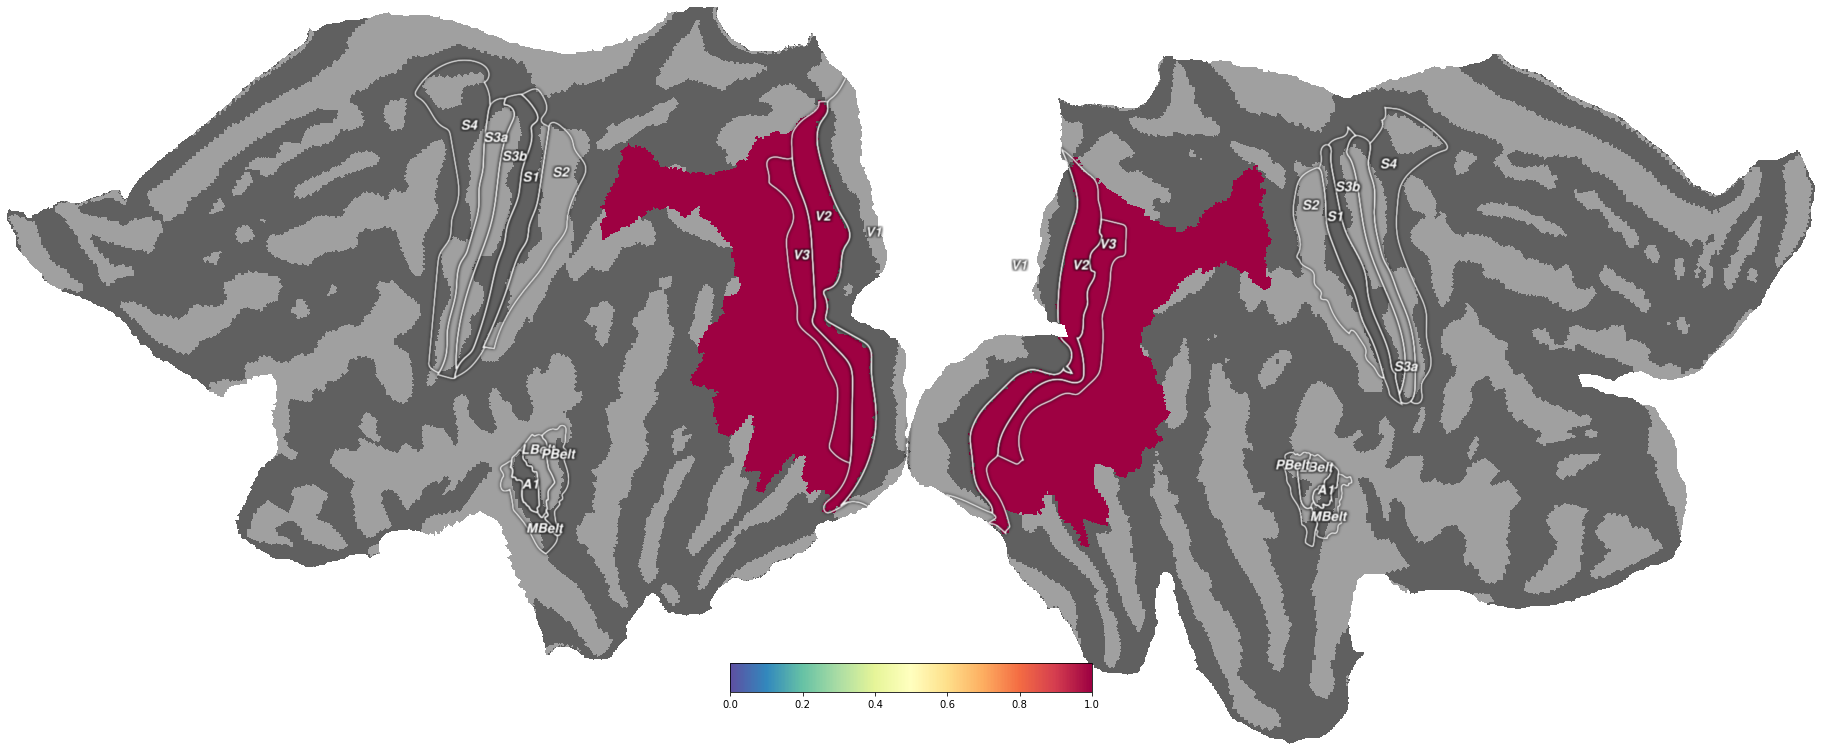

In [501]:
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0.00, vmax=1), with_curvature=True);


In [812]:
import glob
for j, infile in enumerate(natsort.natsorted((glob.glob('/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-*.npy')))):
    print(infile)
    if j == 0:
        dattest = np.load(infile)
    else:
        dattest = np.vstack([dattest, np.load(infile)])



/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-0.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-1.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-2.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-3.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-4.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-5.npy
/tank/klundert/data/DNCF_cortical_fit_sub-169444_fold-0_slice-6.npy


In [810]:
dattest.shape

(13544, 5)

In [772]:
for j, infile in enumerate(natsort.natsorted((glob.glob('/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-*.npy')))):
    print(infile)
    if j == 0:
        dattest = np.load(infile)
    else:
        dattest = np.vstack([dattest, np.load(infile)])
        
        
for j, infile in enumerate(natsort.natsorted((glob.glob('/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-*.npy')))):
    print(infile)
    if j == 0:
        dattest2 = np.load(infile)
    else:
        dattest2 = np.vstack([dattest2, np.load(infile)])
        
        
for j, infile in enumerate(natsort.natsorted((glob.glob('/tank/klundert/data/CF_cortical_fit_sub-100610_fold-1_slice-*.npy')))):
    print(infile)
    if j == 0:
        dattest3 = np.load(infile)
    else:
        dattest3 = np.vstack([dattest3, np.load(infile)])

/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-0.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-1.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-2.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-3.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-4.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-5.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-6.npy
/tank/klundert/data/CF_logvis_fit_sub-100610_fold-1_slice-7.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-0.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-1.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-2.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-3.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-4.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-5.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-6.npy
/tank/klundert/data/CF_vis_fit_sub-100610_fold-1_slice-7.npy


In [694]:
# dirFiles = ['Picture 03.jpg', '02.jpg', '1.jpg']
# dirFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# print(dirFiles)
# # ['1.jpg', '02.jpg', 'Picture 03.jpg']
natsort.natsorted(glob.glob('/tank/klundert/data/CF_vis*.npy'))


['/tank/klundert/data/CF_vis_fit_sub-100610_slice-0.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-1.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-2.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-3.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-4.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-5.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-6.npy',
 '/tank/klundert/data/CF_vis_fit_sub-100610_slice-7.npy']

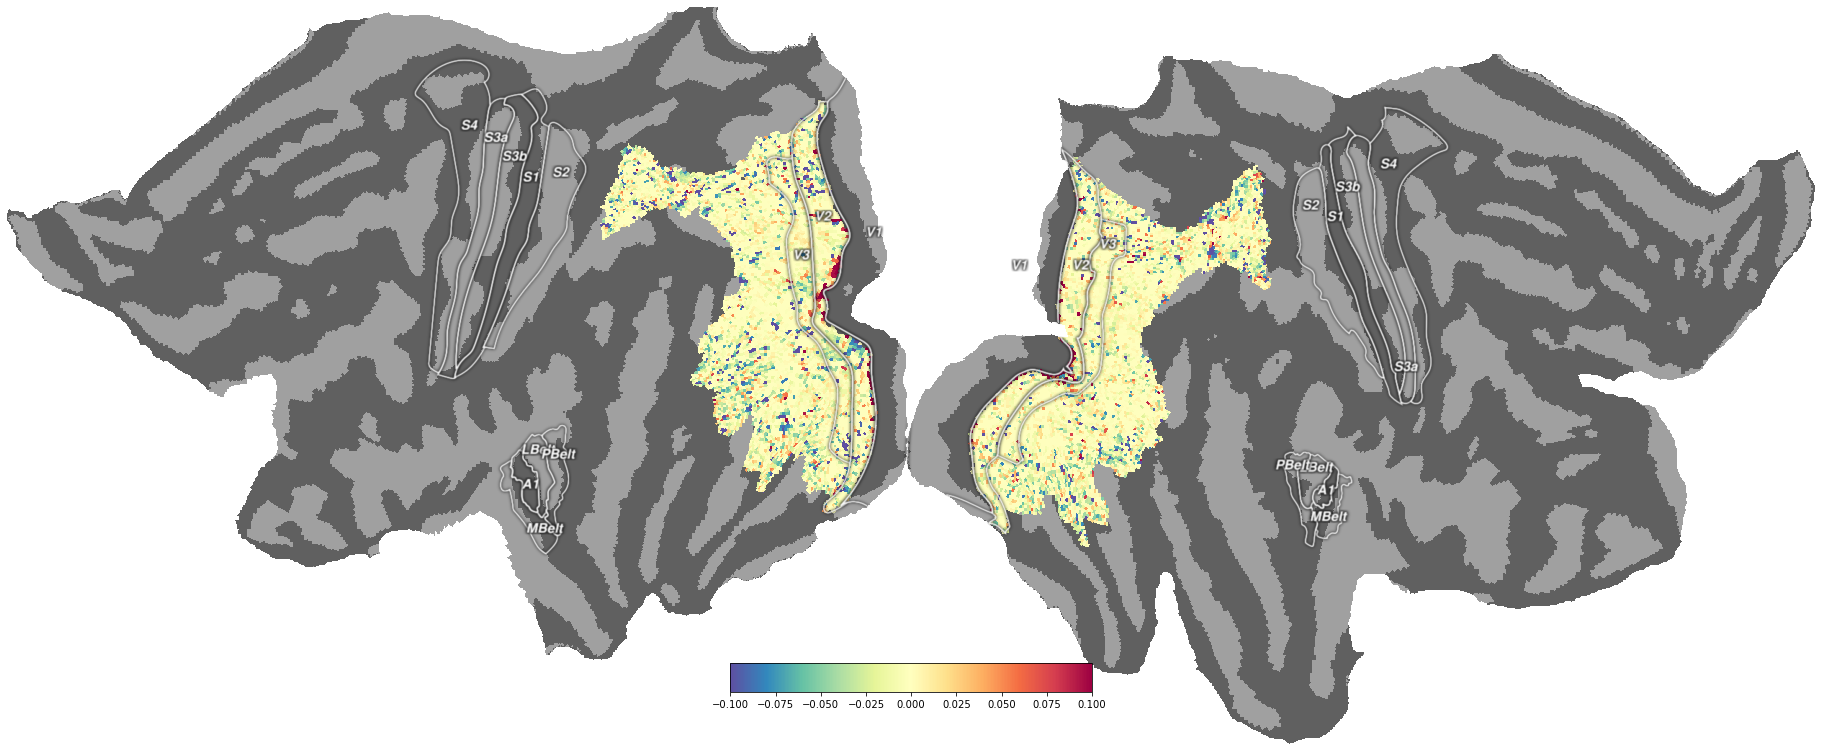

In [775]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
# datass = np.load('/tank/klundert/projects/cfdn/scripts/data_check_100610.npy')
toplot[boolmask] = dattest[:,-1] - dattest2[:,-1]
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=-0.1, vmax=0.1), with_curvature=True);

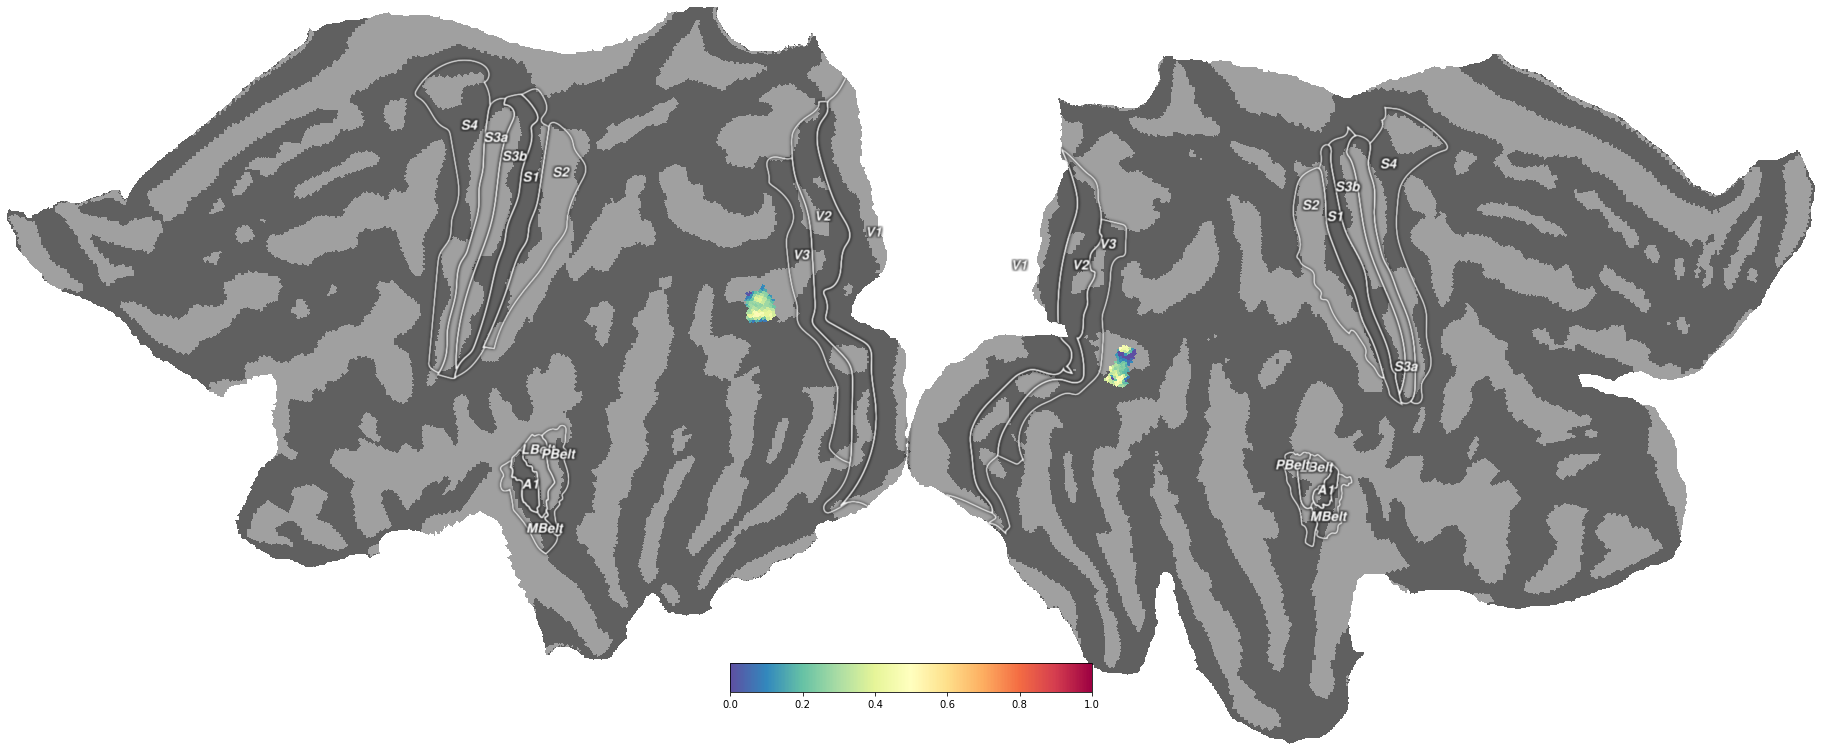

In [284]:
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0.00, vmax=1), with_curvature=True);


In [566]:
import glob
for j, infile in enumerate(sorted(glob.glob('/tank/klundert/projects/cfdn/scripts/*.npy'), key=os.path.getmtime)):
    if j == 0:
        dattest = np.load(infile)
    else:
        dattest = np.vstack([dattest, np.load(infile)])
    

In [ ]:
'tank/klundert/projects/cfdn/scripts/data_check_sub-100610_slice-446.npy

In [447]:
lol = np.vstack([np.load('/tank/klundert/projects/cfdn/scripts/data_check_sub-100610_slice-446.npy'), np.load('/tank/klundert/projects/cfdn/scripts/data_check_sub-100610_slice-447.npy')])

In [507]:
ROImask.sum()
boolmask.sum()

13544

In [543]:
import numpy as np
from IPython import embed as shell
import re
import os
import scipy.io as io
import nibabel as nb
import time
import sys
import h5py
from nilearn.surface import load_surf_data
sys.path.append('/tank/klundert/projects/cfdn/scripts/')





#################################
subs = [100610]
n_jobs = 23
ROImask = np.load(f'/scratch/2021/nprf_ss/derivatives/cf-fits/Surface_dm/visual_mask_hcp.npy')


# roi_index_dict = {
#     # somatosensory:
#     'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
#     # auditory:
#     'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
#     # low-level visual:
#     'V1': 1, 'V2': 4, 'V3': 5,
#     # mid-level and high-level visual:
#     'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
#     'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
#     }

# atlas_data = np.concatenate([load_surf_data(
#         os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
#          for hemi in ['L', 'R']])
# atlas_data_both_hemis = np.mod(atlas_data, 180)


# ROImask = atlas_data_both_hemis == roi_index_dict[mask]


chunkedmasks = [boolmask[i:i+9882] for i in range(0,len(boolmask),9882)]

for sub in subs:
    chunk_n = 0
    for slice_n, chunk in enumerate(chunkedmasks):
        if chunk.sum() > 0:
            print(chunk_n)
            
        
#             jobscript = open('jobscript_base.sh')
#             working_string = jobscript.read()
#             jobscript.close()

#             RE_dict =  {
#             '---sub---': str(sub),
#             '---n_jobs---': str(n_jobs),
#             '---slice_n---': str(slice_n),
#             '---chunk_n---': str(chunk_n)}


#             for e in RE_dict:
#                 rS = re.compile(e)
#                 working_string = re.sub(rS, RE_dict[e], working_string)

#             of = open('jobscript', 'w')
#             of.write(working_string)
#             of.close()
#             print(working_string)
#             os.system(working_string)
            chunk_n = chunk_n + 1

0
1
2
3
4
5
6
7


In [555]:
def split_given_size(a, size):
    return np.split(a, np.arange(size,len(a),size))

0

1.5707964
4.710741


In [11]:
xs, ys = [], []
for sub in ab.full_data_subjects:
    datvol = nb.load(f'/tank/klundert/hcp_benson/lh_{sub}_angle.func.gii')
    datvol2 = nb.load(f'/tank/klundert/hcp_benson/rh_{sub}_angle.func.gii')
    datvol3 = nb.load(f'/tank/klundert/hcp_benson/lh_{sub}_eccen.func.gii')
    datvol4 = nb.load(f'/tank/klundert/hcp_benson/lh_{sub}_eccen.func.gii')
    
    ecc_l = datvol3.agg_data()
    ecc_r = datvol4.agg_data()
    lh = datvol.agg_data()
    rh = datvol2.agg_data()
#     lh[lh>=90] = (lh[lh>=90]*-1)+270
#     lh[lh<90] = lh[lh<90] + 90
#     rh = rh - 90
    x = np.concatenate([position(ecc_l, -lh+90)[0], position(ecc_r, -rh+270)[0]])
    y = np.concatenate([-position(ecc_l, -lh+90)[1], position(ecc_r, -rh+270)[1]])
    
    xs.append(x)
    ys.append(y)
#     ecc_t = ecc(y, x)
#     ecc_t[~V1_mask] = np.nan
#     cx.quickshow(cx.Vertex(ecc_t, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=80), with_curvature=True)


Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: divide by zero encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: invalid value encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide by zero encountered in true_divide
  return a/(b+x)
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide by zero encountered in true_divide
  return a/(b+x)


[17.24640337  0.51992803]
[17.24640337  0.51992803]


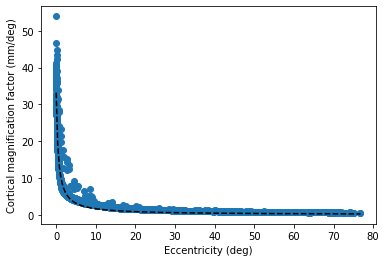

In [859]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]



myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

# load prf paramaters for creating visual space distance matrix and limiting the vertices

gfn_ecc = ecc(benY, benX)
gfn_rsq = V1_params_full[:,-1]
# max_ecc_size = ab.prf_ecc_threshold
max_ecc_size = 120
maxrsq = -1
# maxrsq = np.nanmax(gfn_rsq)

# myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq)
myv1surf.create_visual_space(benY, benX)

In [851]:
myv1surf.visual_distance_matrix.shape

(2890, 2890)

In [709]:
myv1surf.visual_distance_matrix - myv1surf.logvisual_distance_matrix


array([[  0.      ,   0.      ,   0.      , ..., -12.047658, -40.626205,
        -29.321993],
       [  0.      ,   0.      ,   0.      , ..., -12.047658, -40.626205,
        -29.321993],
       [  0.      ,   0.      ,   0.      , ..., -12.047658, -40.626205,
        -29.321993],
       ...,
       [-12.047658, -12.047658, -12.047658, ...,   0.      , -28.714815,
        -18.201828],
       [-40.626205, -40.626205, -40.626205, ..., -28.714815,   0.      ,
        -12.683514],
       [-29.321993, -29.321993, -29.321993, ..., -18.201828, -12.683514,
          0.      ]], dtype=float32)

0.0

In [608]:
myv1surf.tofit_x

135        0.000000
136        0.000000
137        0.000000
138        0.000000
139        0.629706
            ...    
106222    25.869276
106252     0.000000
106259     0.560083
106260     8.406274
106261     2.835280
Name: eccentricity, Length: 2890, dtype: float32

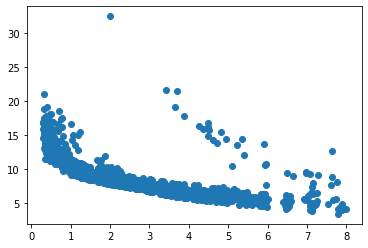

In [616]:
plt.scatter(myv1surf.tofit_x, myv1surf.tofit_y)

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/downloads/prfpy/prfpy/utils.py:166: RuntimeWarning: invalid value encountered in less
  eccMask = ecc < maxecc
/tank/klundert/downloads/prfpy/prfpy/utils.py:167: RuntimeWarning: invalid value encountered in greater
  rsqMask = rsq > maxrsq
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: divide by zero encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:223: RuntimeWarning: invalid value encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide by zero encountered in true_divide
  return a/(b+x)
/tank/klundert/downloads/prfpy/prfpy/utils.py:304: RuntimeWarning: divide b

[48.35656104  3.16327226]
[48.35656104  3.16327226]


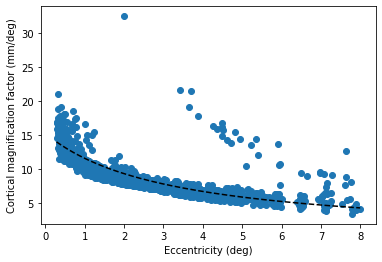

In [731]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

# load prf paramaters for creating visual space distance matrix and limiting the vertices
what = h5py.File(ab.prf_parameter_h5file, "r")
V1_params = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L']), np.array(what['prf_iterative_parameters']['v1_R'])])
V1_params_full = np.zeros([118584, 6])
V1_params_full[:] = np.nan
V1_params_full[boolmask] = V1_params
V1_params_full[~V1_mask] = np.nan
gfn_ecc = ecc(V1_params_full[:,0], V1_params_full[:,1])
gfn_rsq = V1_params_full[:,-1]
# max_ecc_size = ab.prf_ecc_threshold
max_ecc_size = 8
maxrsq = 0.0001
# maxrsq = np.nanmax(gfn_rsq)

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq)
myv1surf.create_visual_space(V1_params_full[:,0], V1_params_full[:,1])

In [842]:
12+11+14

37

In [840]:
np.save('/tank/klundert/hcp_benson/XandY.npy', np.vstack([benX, benY]))

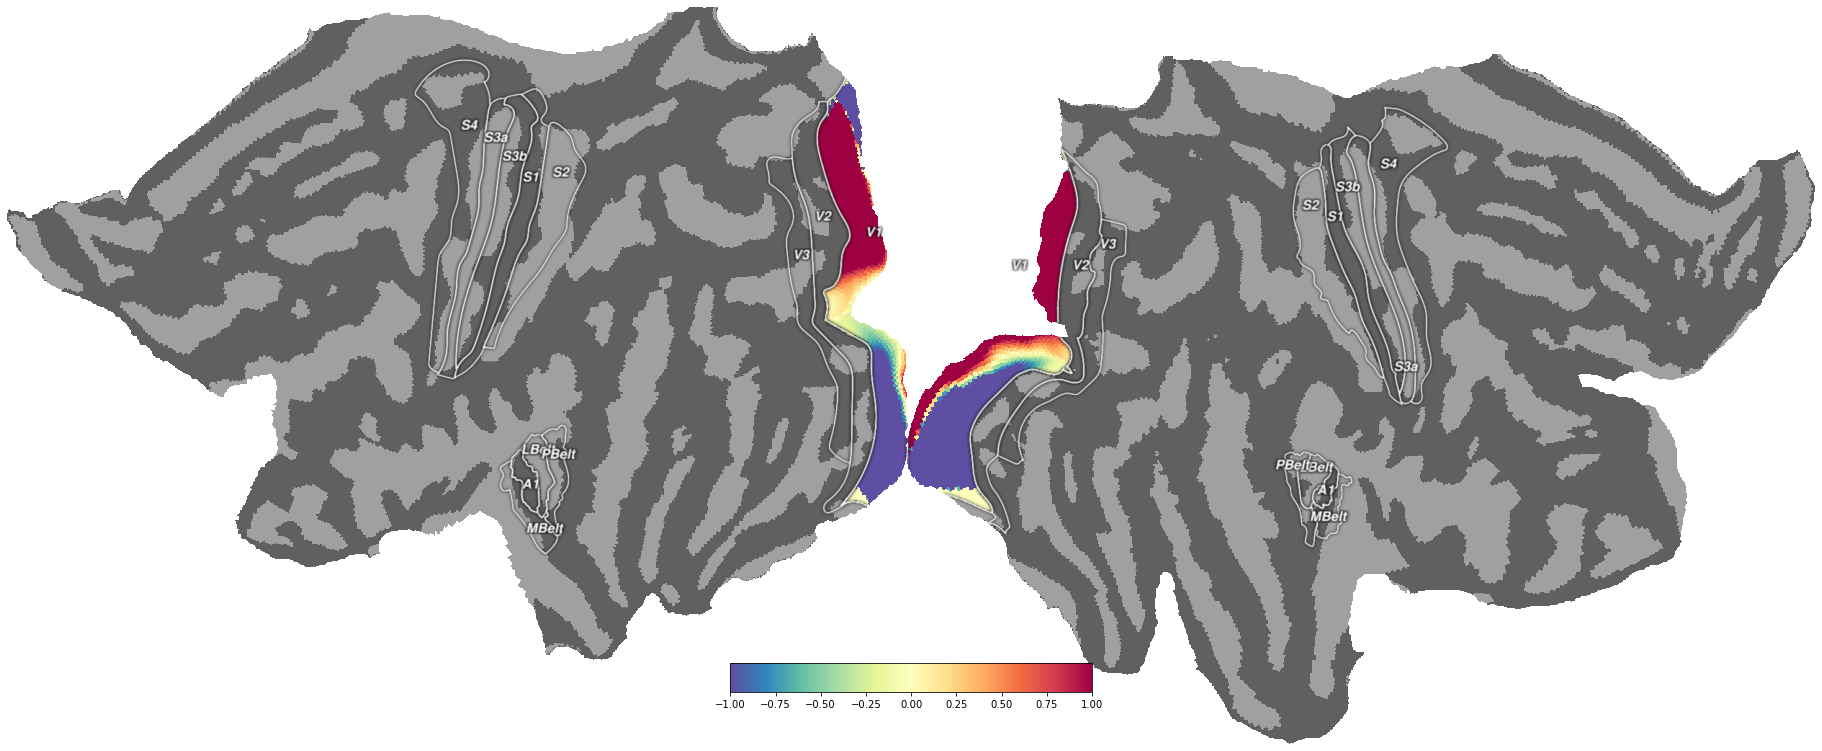

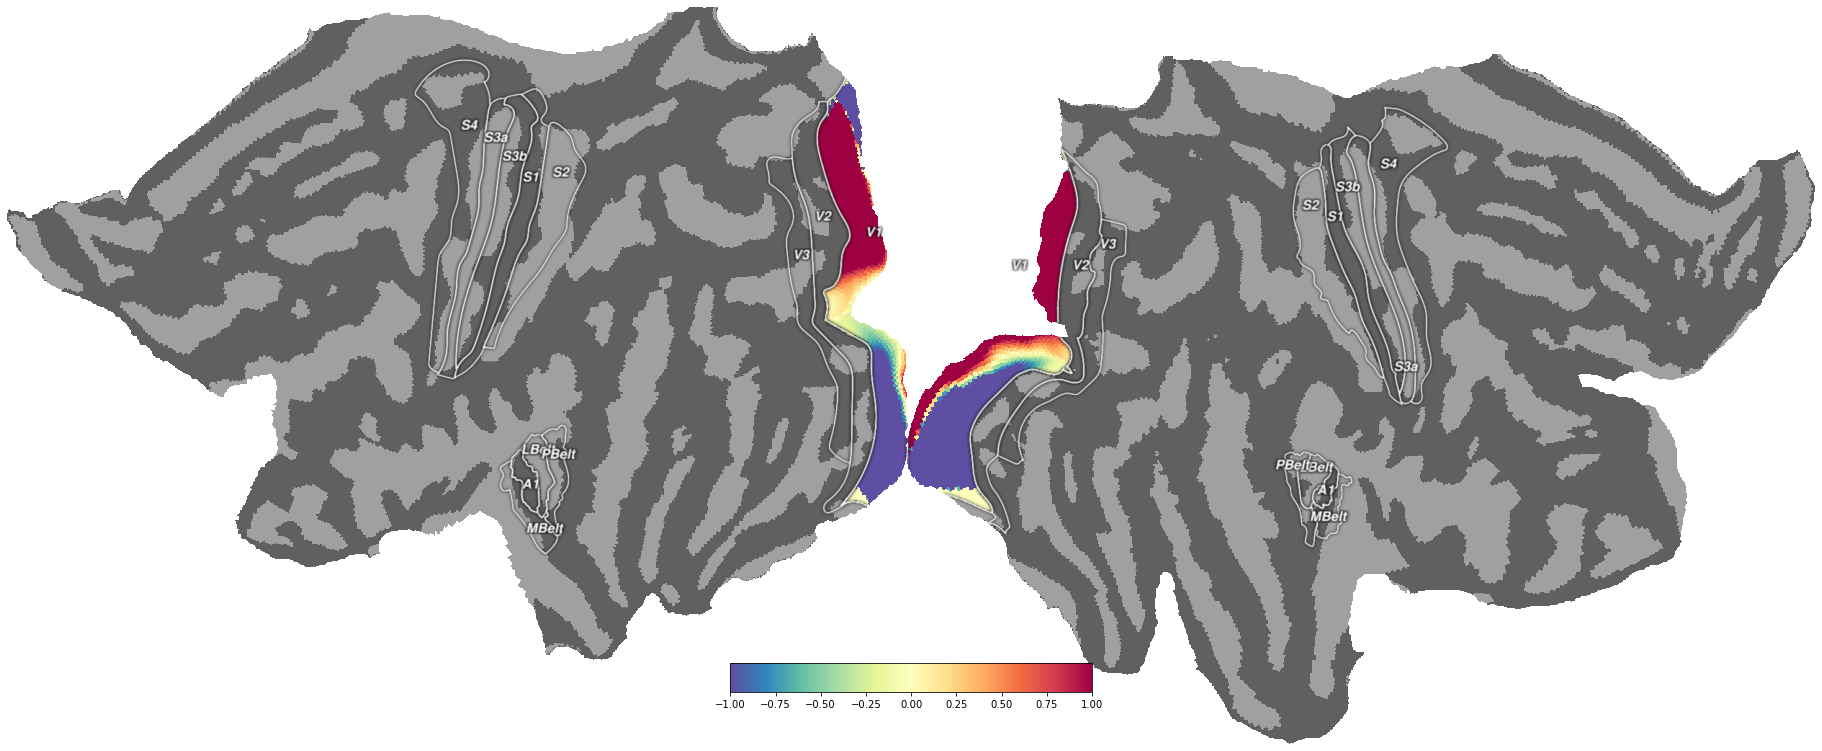

In [9]:
benX.shape

()

In [5]:
benX, benY = np.load('/tank/klundert/hcp_benson/XandY.npy')

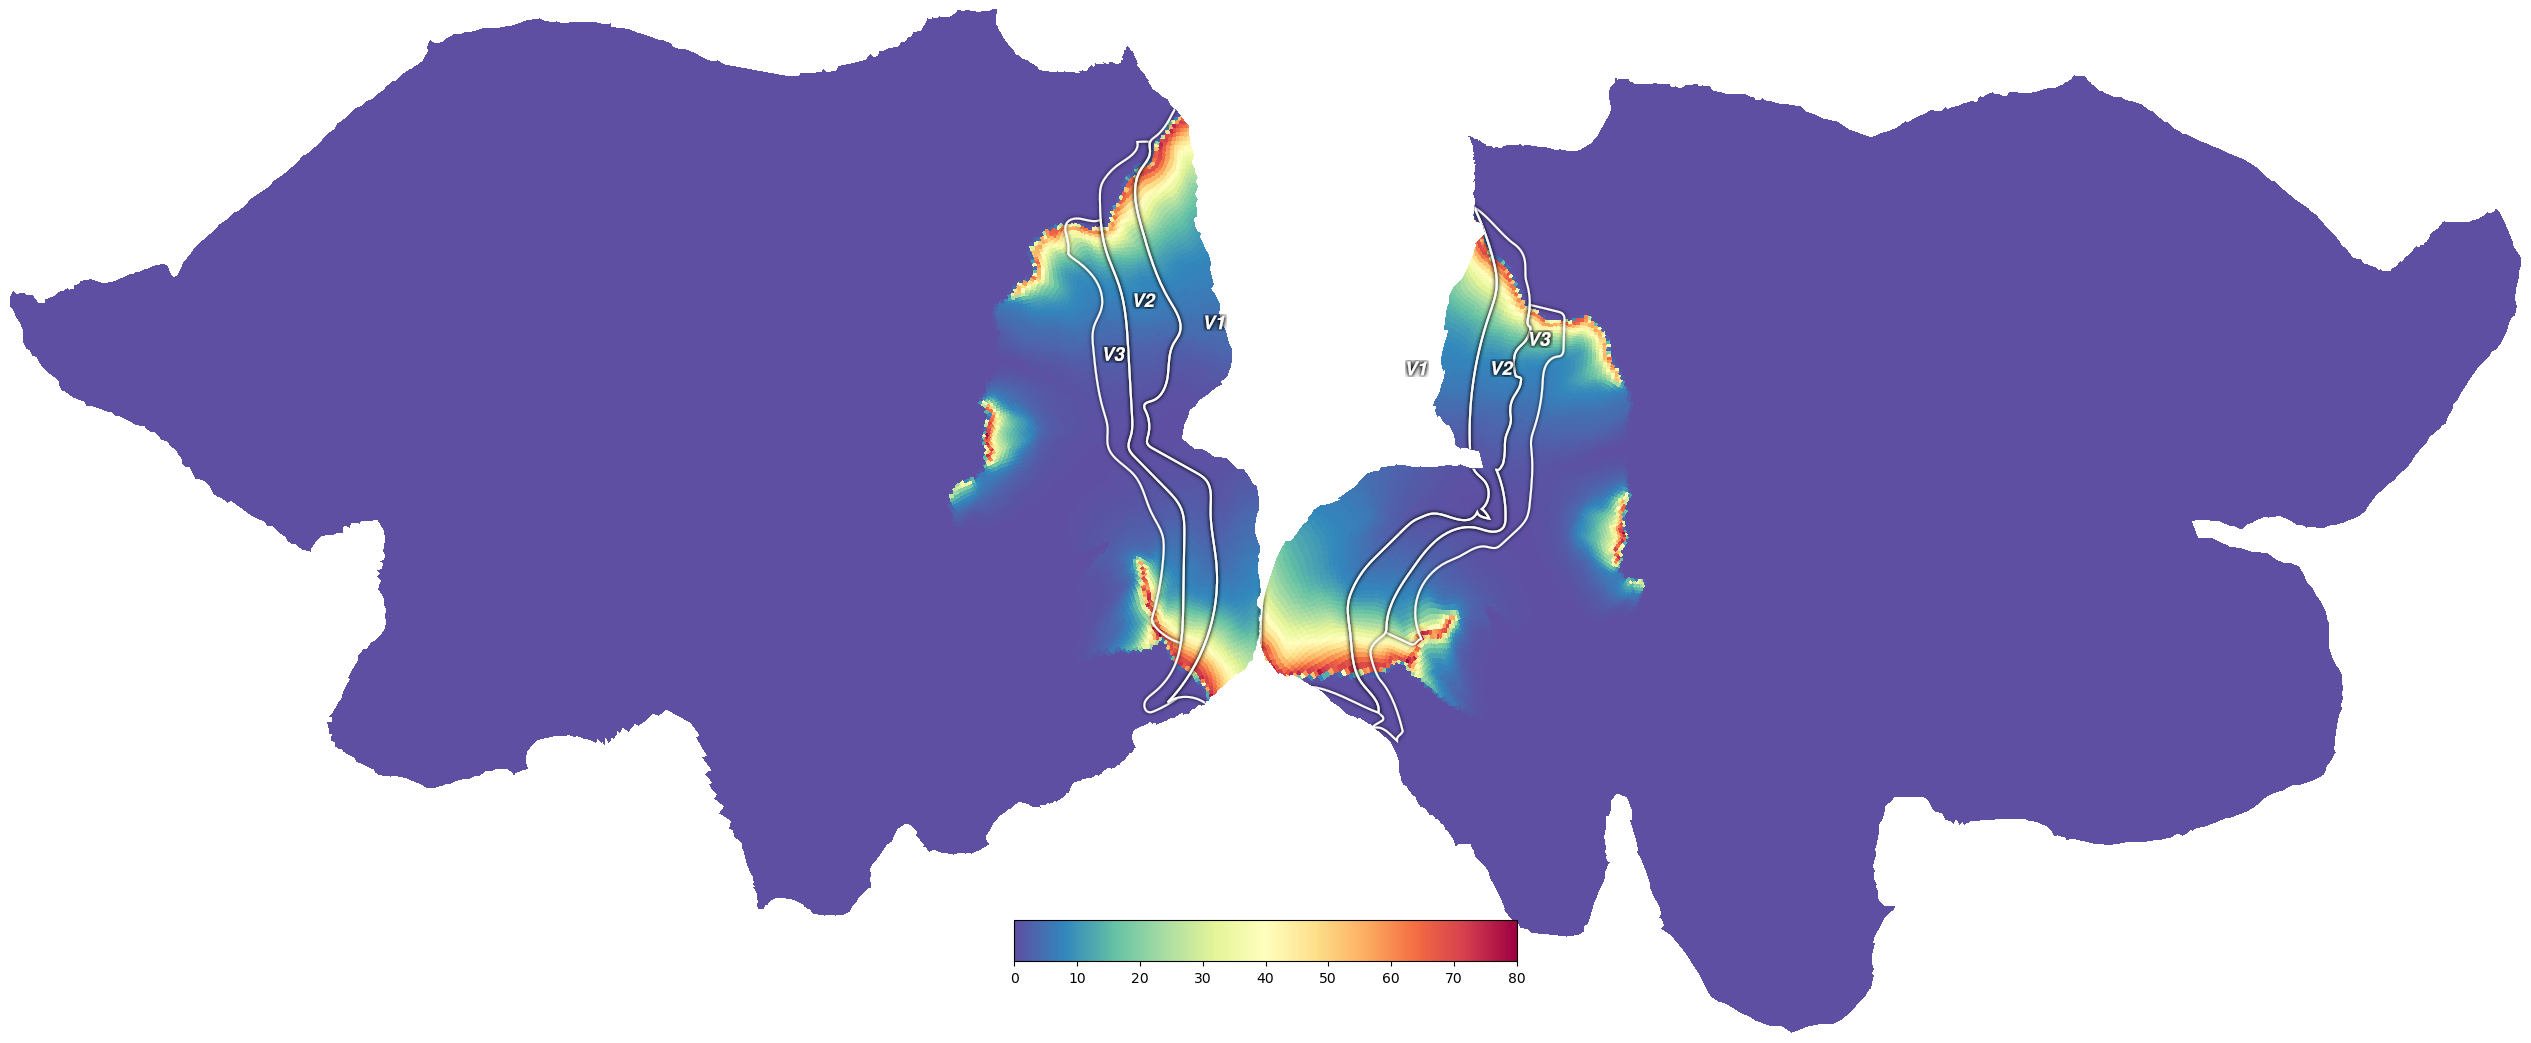

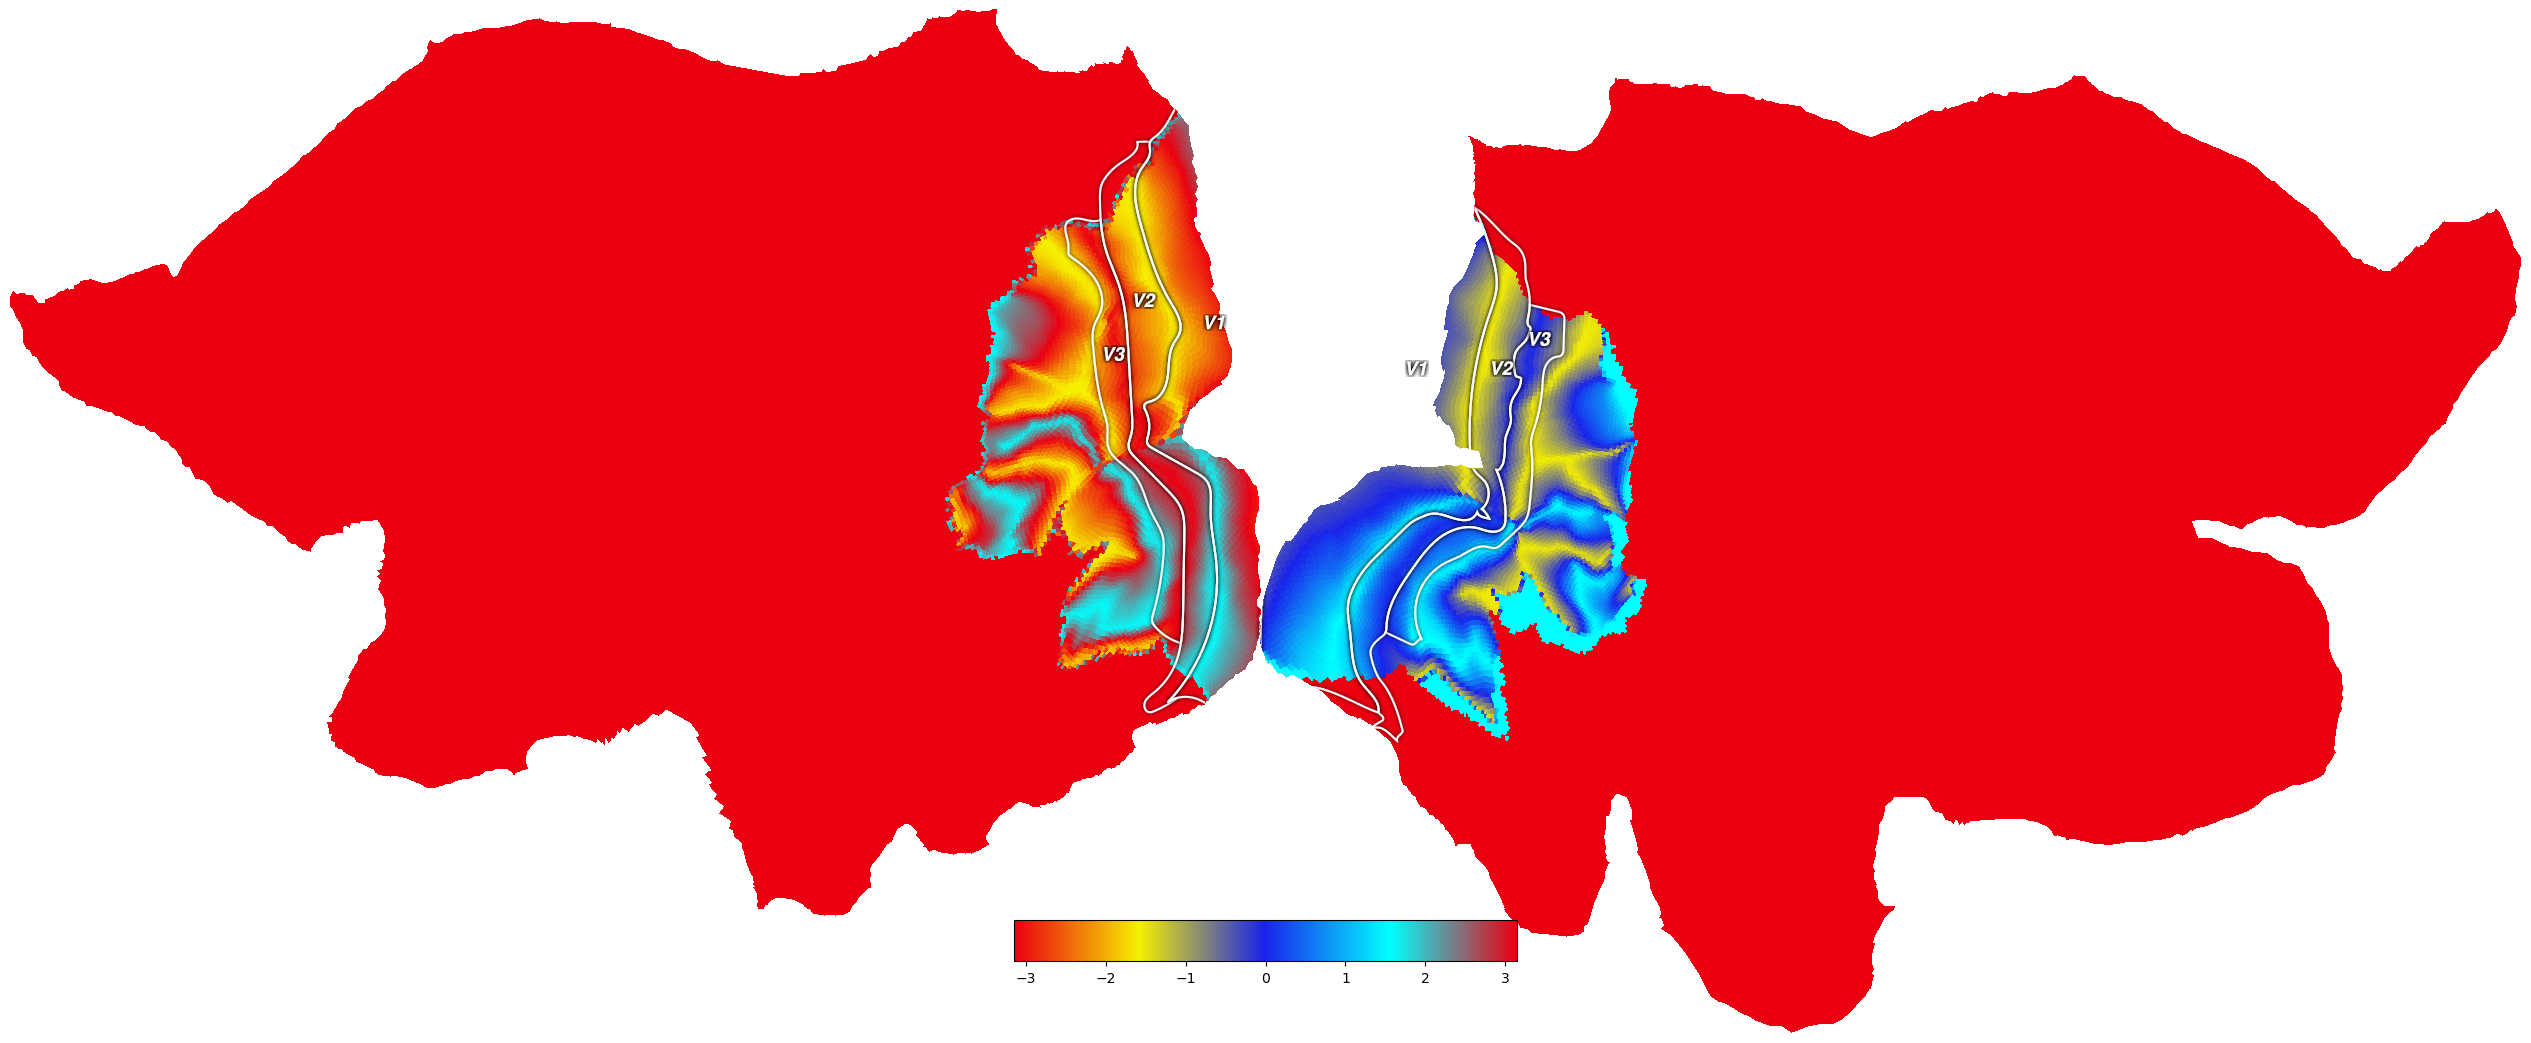

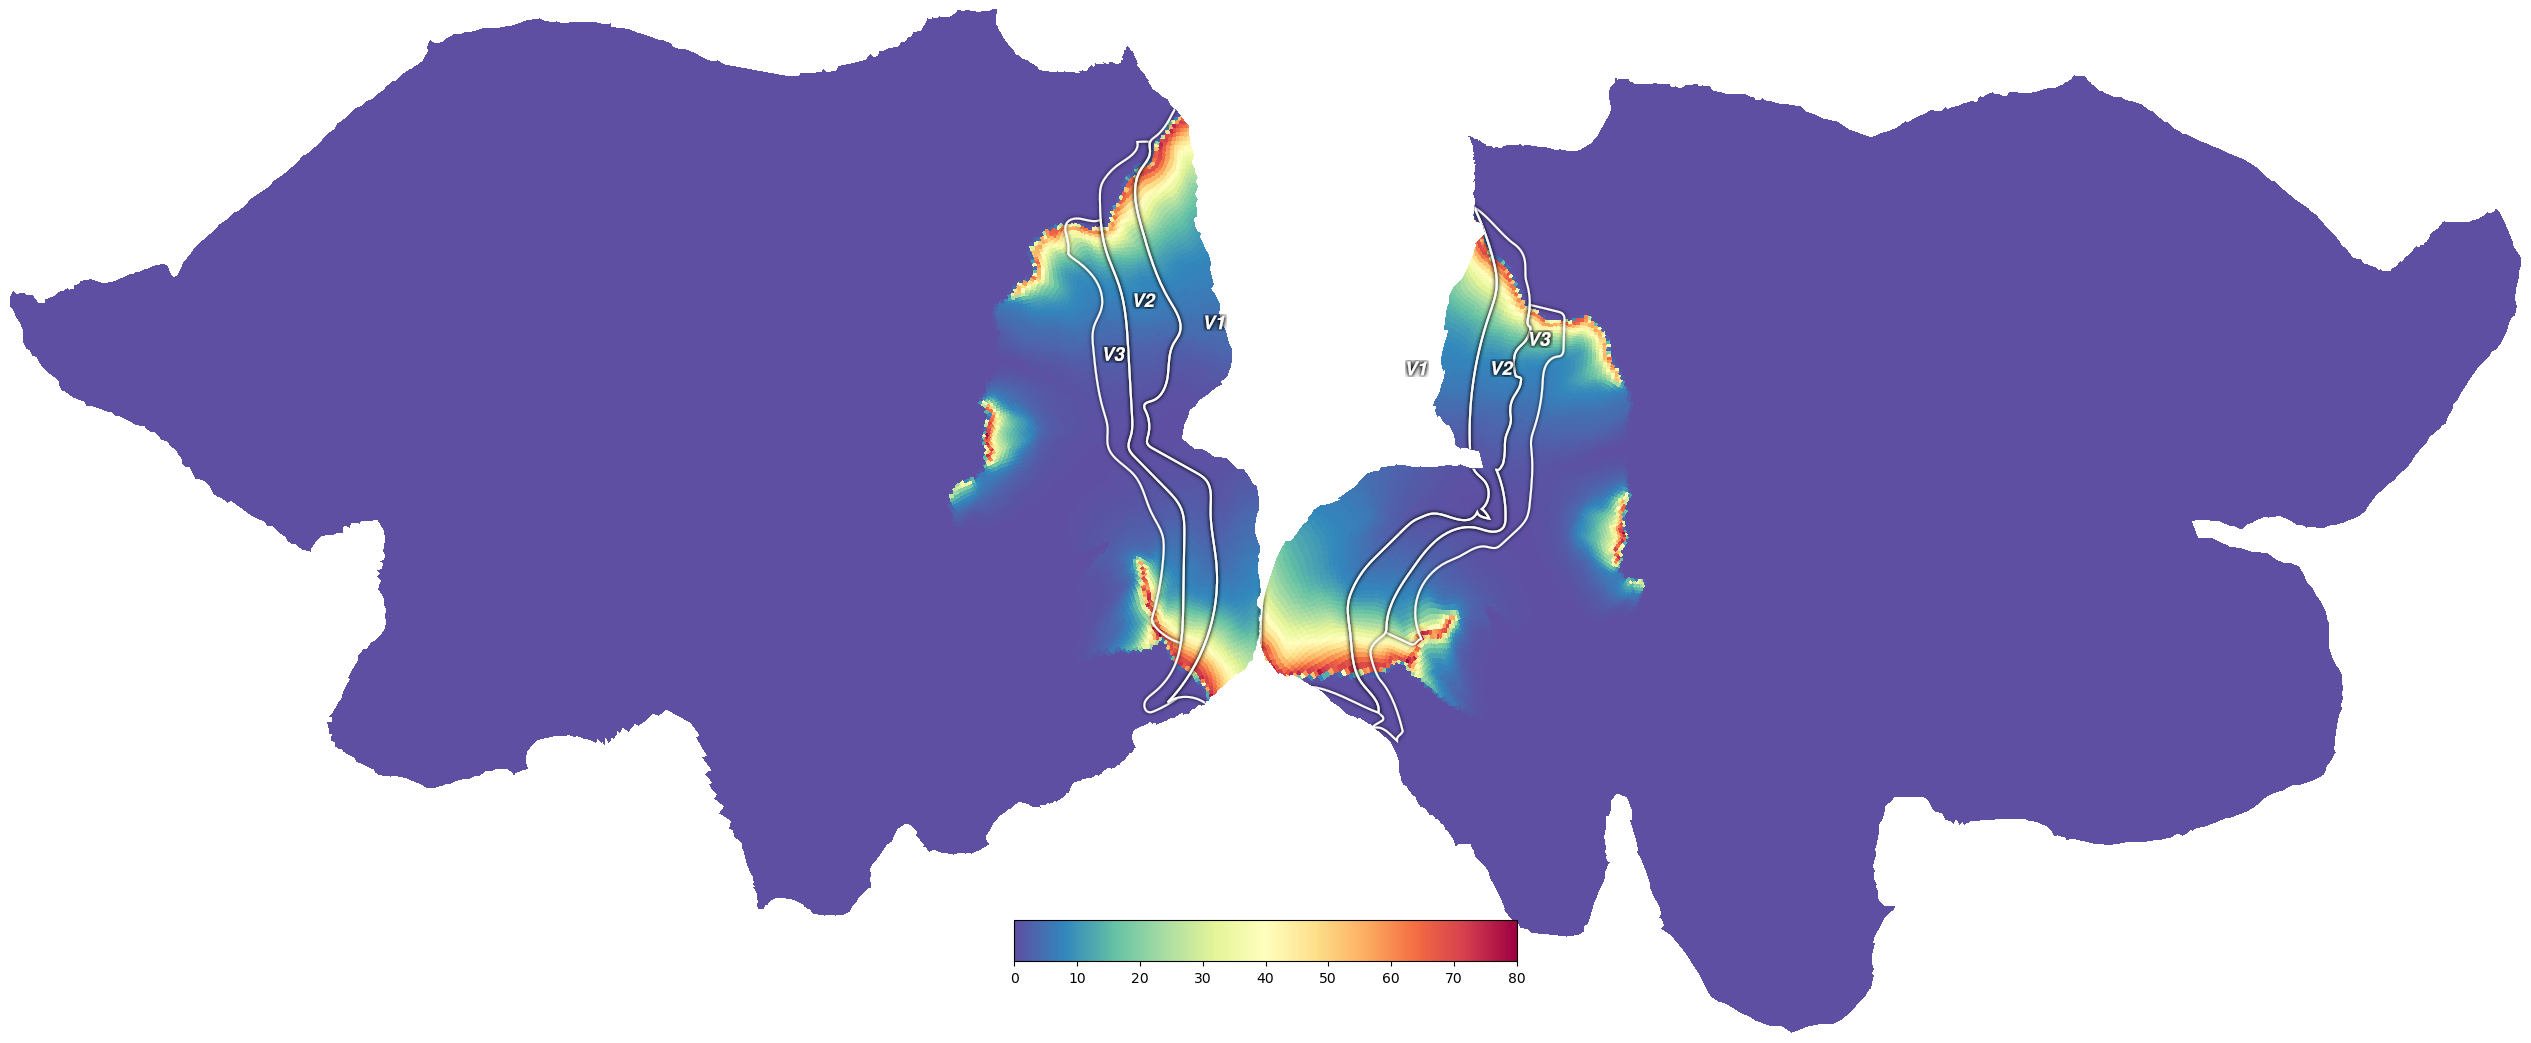

In [14]:
# benX = np.mean(xs, axis=0)
# benY = np.mean(ys, axis=0)

# benX[~V1_mask] = np.nan
# benY[~V1_mask] = np.nan

cx.quickshow(cx.Vertex(angle(benX*-1, benY*-1), subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True)
cx.quickshow(cx.Vertex(ecc(benX, benY), subject='hcp_999999', cmap='spectral_r', vmin=0, vmax=80), with_curvature=True)

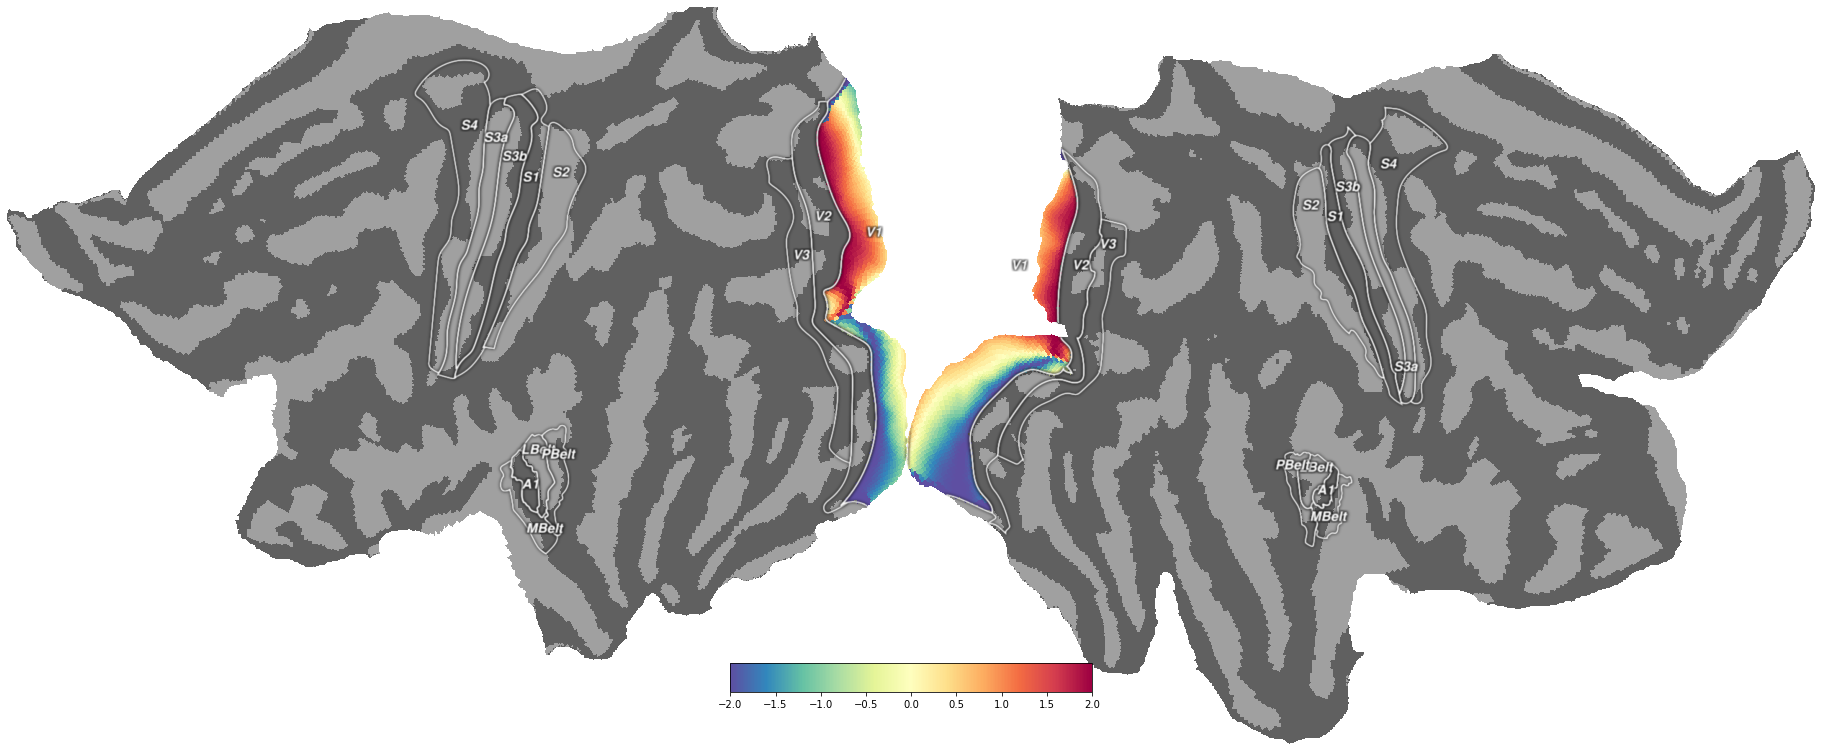

In [522]:

for sub in ab.full_data_subjects[:1]:
    datvol = nb.load(f'/tank/klundert/hcp_benson/lh_{sub}_angle.func.gii')
    datvol2 = nb.load(f'/tank/klundert/hcp_benson/rh_{sub}_angle.func.gii')
    lh = datvol.agg_data()
    rh = datvol2.agg_data()
#     lh[lh>=90] = (lh[lh>=90]*-1)+270
#     lh[lh<90] = lh[lh<90] + 90
#     rh = rh - 90
    
    ecc_t = np.concatenate([position(2, -lh+90)[1], position(2, -rh+270)[1]])
    ecc_t[~V1_mask] = np.nan
    cx.quickshow(cx.Vertex(ecc_t, subject='hcp_999999', cmap='spectral_r', vmin=-2, vmax=2), with_curvature=True)


In [543]:
for sub in ab.full_data_subjects:
    datvol = nb.load(f'/tank/klundert/hcp_benson/lh_{sub}_angle.func.gii')

In [549]:
len(glob.glob(f'/tank/klundert/hcp_benson/lh_*'))

696/4

174.0

In [468]:
prf_check = get_cortex(np.load('/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/gaussian-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy'))

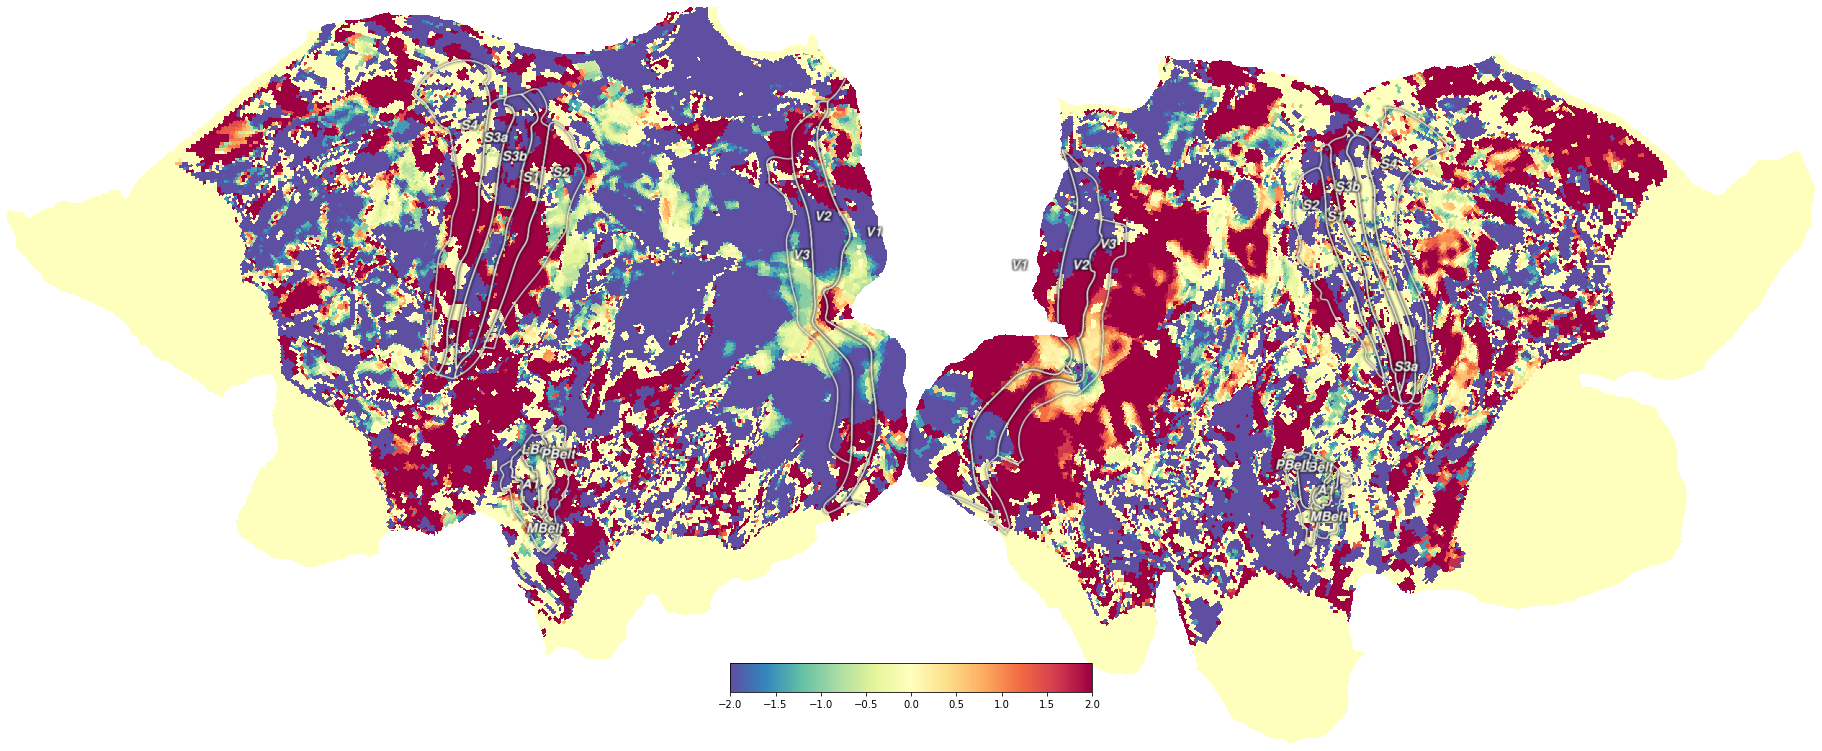

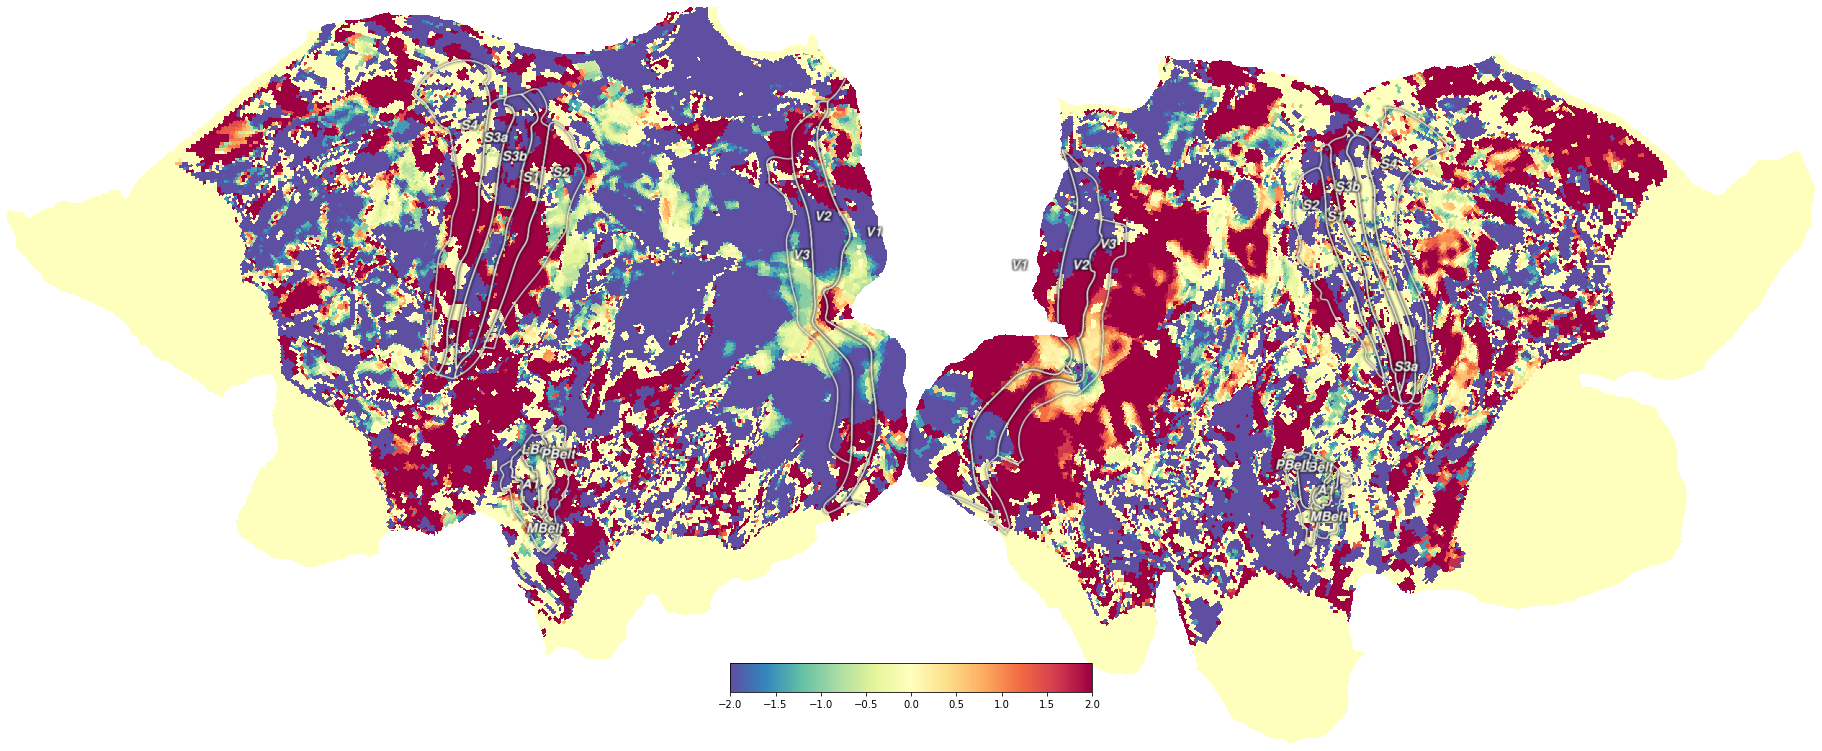

In [472]:
cx.quickshow(cx.Vertex(prf_check[:,1], subject='hcp_999999', cmap='spectral_r', vmin=-2, vmax=2), with_curvature=True)


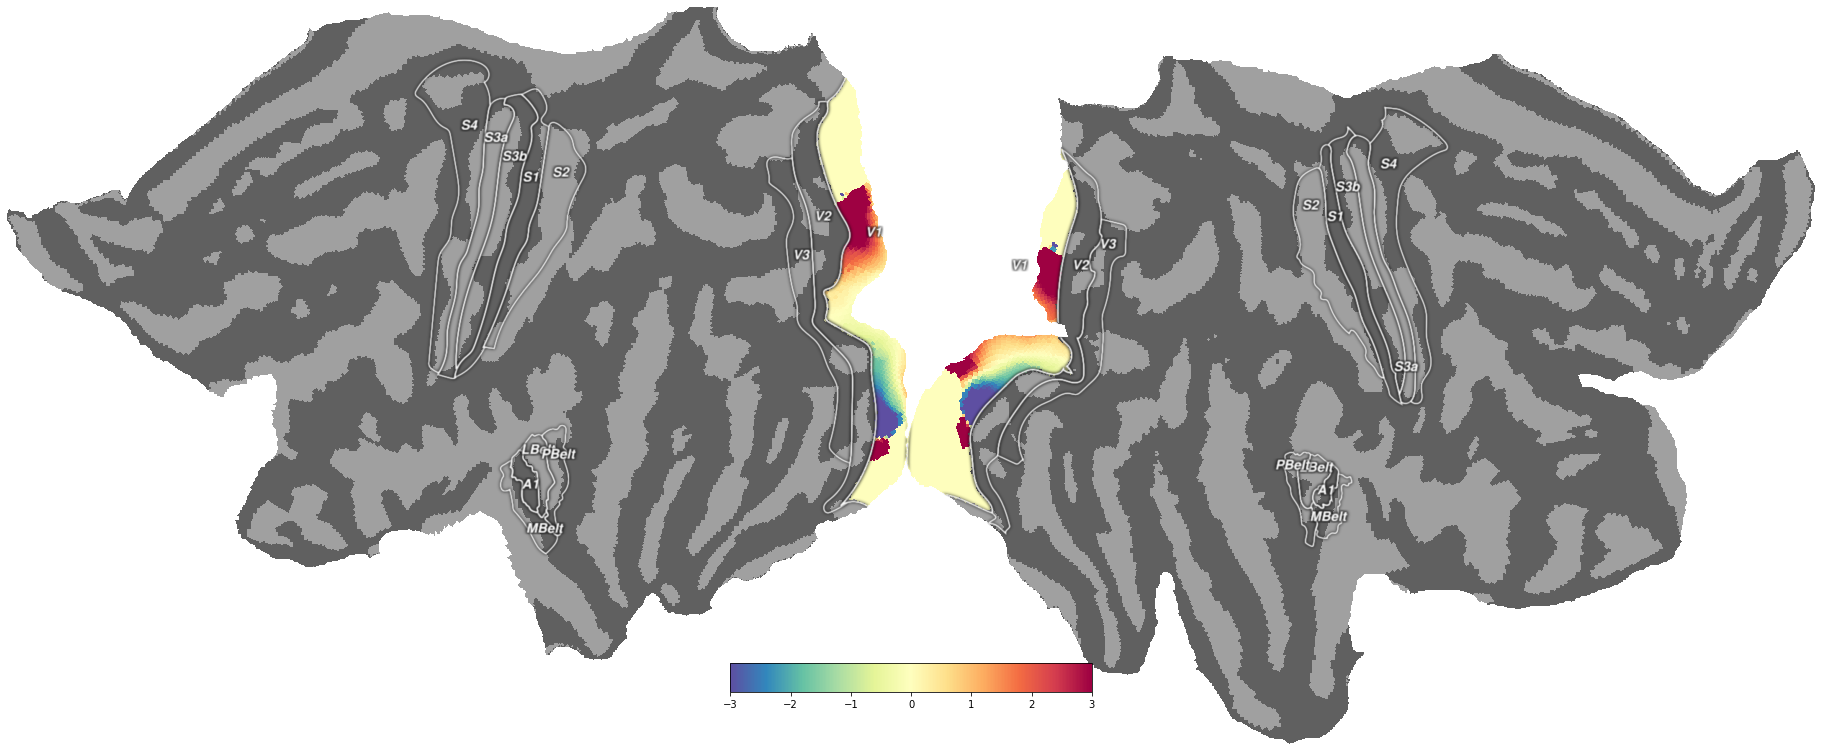

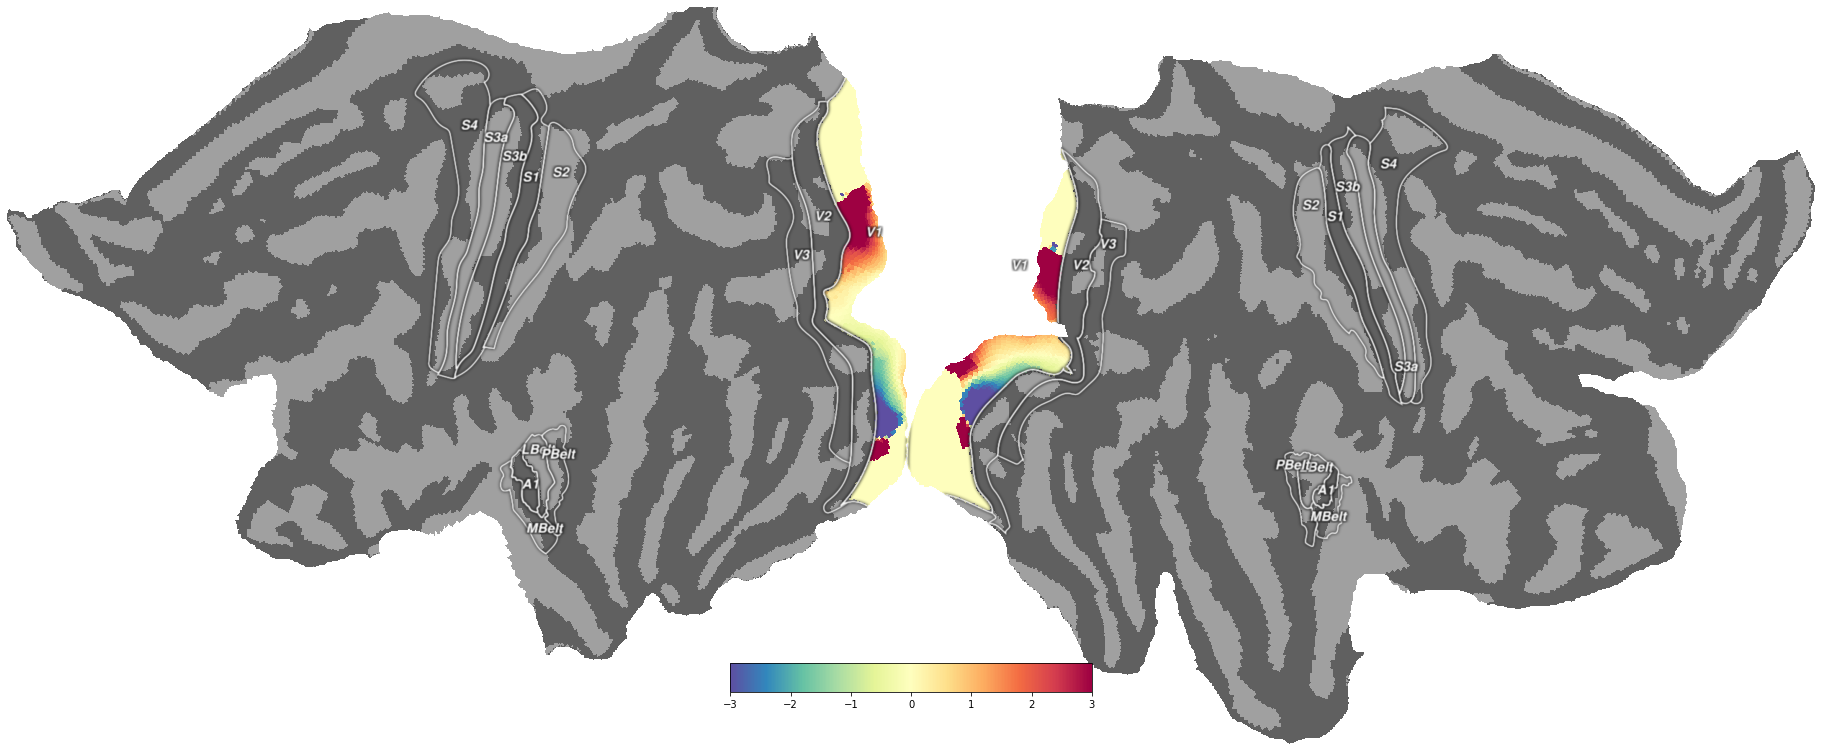

In [521]:
toplot=np.zeros(118584,)
toplot[:] = np.nan
toplot[boolmask] = V1_params[:,0]
toplot[~V1_mask] = np.nan
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-3, vmax=3), with_curvature=True)

In [478]:
# cx.webgl.show(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-2, vmax=2), port=8810)

In [489]:
np.array(what['prf_grid_parameters']['v1_L']).shape

(1509, 6)

In [499]:
V1_params.shape

(2939,)

In [10]:
import numpy as np

def position(dist, angle):
    """ returns the x and y coordinates given an angle in degrees and a distance in clockwise direction """
    return dist * np.cos(np.deg2rad(angle)), dist * np.sin(np.deg2rad(angle))

In [399]:
# x, y = -1, -1
# print(angle_deg(x,y))
# position(ecc(x,y), 225)

-1*lh+90 == -lh+90

1.0

In [367]:
lh = datvol.agg_data()
rh = datvol2.agg_data()

In [392]:
angle(position(2, -lh+90)[0], position(2, -lh+90)[1])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 59292 but corresponding boolean dimension is 118584

In [413]:
# def angle(x0, y0):
#     return np.angle(x0 + y0 * 1j)


angle(0, 1)

1.5707963267948966

In [843]:
ab._read_tc_data(run=0).shape

Getting whole-brain data from: /scratch/2019/visual/hcp_ret/subjects/999999/tfMRI_RETBAR1_*_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc.nii


(300, 170494)

In [717]:
mysuppdicts=[dict({'---subject---':str(p),'---data_portion---':str(dp)}) for p in range(174) for dp in range(8)]

/tank/klundert/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(71,)

In [712]:
for p in [6, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 47]:
    print(p)

6
12
13
15
16
17
18
19
20
21
24
25
47


In [ ]:
cx.webgl.show(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-2, vmax=2), port=8810)

In [574]:
with open('/tank/klundert/projects/cfdn/scripts/analysis_settings.yml') as f:
    analysis_info = yaml.safe_load(f)

In [801]:
for i in range(174):
    analysis_info['analysis']['full_data_subjects'][i]


In [612]:
# d = []
# for p in game.players.passing():
#     d.append(
#         {
#             'Player': p,
#             'Team': p.team,
#             'Passer Rating':  p.passer_rating()
#         }
#     )

# pd.DataFrame(d)

t = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L'])[:,-1], np.array(what['prf_iterative_parameters']['v1_R'])[:,-1]])
np.mean(t)

0.08288620397581913

In [740]:
# # d = []

# for subbies in analysis_info['analysis']['full_data_subjects']:
#     print(subbies)
#     what = h5py.File(f'/scratch/2019/visual/hcp_ret/subjects/{subbies}/V12_retmap_results_polar_bar_iterative.h5', "r")
#     t = np.concatenate([np.array(what['prf_iterative_parameters']['v1_L'])[:,-1], np.array(what['prf_iterative_parameters']['v1_R'])[:,-1]])
#     print(np.median(t))
ac.startup(subject='177140', experiment_id="ret", yaml_file="/tank/klundert/projects/hcp_movie/config.yml")
mydat_train_stim2 = get_cortex(ac._read_tc_data(run=0).T)


Starting analysis of subject 177140 on romulus with settings 
{
 "identifier": "node230",
 "base_dir": "/scratch/2019/visual/hcp_{experiment}/",
 "code_dir": "/tank/tkn219/projects/hcp_movie/",
 "threads": 40
}
Getting whole-brain data from: /scratch/2019/visual/hcp_ret/subjects/177140/tfMRI_RETBAR1_*_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc.nii


In [742]:
mydat_train_stim2.shape

(118584, 300)

In [790]:
np.allclose(mydat_train_stim2.std(axis=1), mydat_train_stim.std(axis=1))

True

No handles with labels found to put in legend.


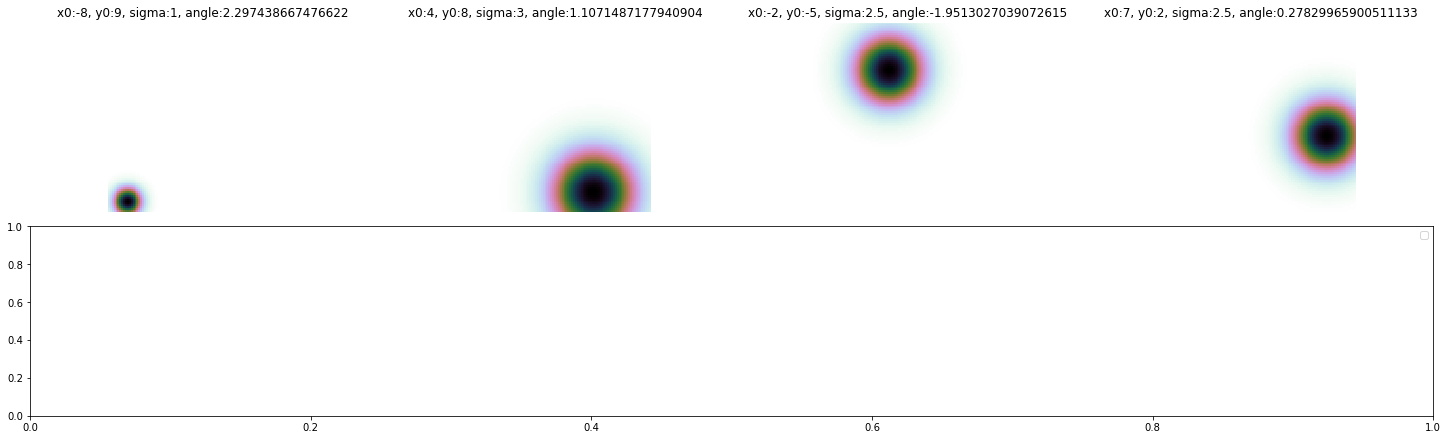

In [900]:
from prfpy.rf import gauss2D_iso_cart
space_1D = np.linspace(-10,10,100,endpoint=True)
X, Y = np.meshgrid(space_1D, space_1D)
# For clarity of the calculation, we make a vector out of the images 
# of both the stimulus and the pRF model by raveling them. 

def model_timecourse(model, stimulus):
    return np.dot(model.ravel(), stimulus.T.reshape((-1,stimulus.shape[0])))

# and we can plot these for a bunch of different pRFs
# and to make it nice, we use a gridspec. Remember this for your report :)
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(20,6))
gs = GridSpec(2, 4, figure=fig)
ax_tc = fig.add_subplot(gs[1,:])

for x0,y0,sigma,i in zip([-8,4,-2,7], [9, 8, -5, 2], [1, 3, 2.5, 2.5], [0,1,2,3]):
    pRF = gauss2D_iso_cart(X, Y, mu=(x0,y0), sigma=sigma, normalize_RFs=False)
    ax_prf = fig.add_subplot(gs[0,i])
    ax_prf.imshow(pRF, cmap='cubehelix_r')
    ax_prf.set_title(f'x0:{x0}, y0:{y0}, sigma:{sigma}, angle:{angle(x0, y0)}')
    ax_prf.axis('off')
    # ax_tc.plot(model_timecourse(pRF, new_dms)**0.5, label=f'x0:{x0}, y0:{y0}, sigma:{sigma}')
ax_tc.legend();